In [28]:
import math
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from scipy.special import expit
from sklearn.model_selection import train_test_split

matplotlib.rcParams.update({'figure.figsize': (15, 9)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})
%config InlineBackend.figure_format = 'retina'

sns.set_style("whitegrid")

# Machine Learning lab 4: extending logistic regression
## Jake Rowland and Paul Herz
2017-10-01

## 1. Introduction

Here we return to the dataset of our initial project, [Exploring Table Data](https://github.com/SMU-ML-2017/Project1/blob/master/ML%20Lab%201.ipynb), wherein we graphically analyzed the trends in the [IMDB Top 5000 Movie Dataset](https://www.kaggle.com/deepmatrix/imdb-5000-movie-dataset). One aspect of our analysis in that project centered around dividing the set of films into three groups: **poor**, **average**, and **good**. This was a simplification of IMDB's 10-point rating system, and grouped films into asymmetric quantiles. It allowed us to cut arbitrary lines in the large group of films to illustrate trends among the upper percentile films versus the rest. Here, we will try to use several classification techniques to predict these three classes, and compare the results. One technique will involve a homespun implementation to display the inner workings of such an algorithm.

### 1.1 Background

This dataset represents data compiled entirely by IMDB, whose primary purpose is as a compendium of films. In the previous use of this dataset, we mostly considered how this dataset serves as a representation of trends in American and international cinema. This time, we want to consider the films more in the context of IMDB as an application, and the trends of American film consumers.

### 1.2 Business Case

Using the same arbitrary classifications of **poor**, **average**, and **good**, whose definitions depend on the quantile groupings of IMDB out-of-10 scores, we want to use film data (less the scores) to predict a film's classification into one of these groups. We believe that such a feature will be useful to IMDB, which is likely to receive a sizeable portion of traffic from visitors looking up brand-new films. However, brand-new films do not have sufficient reviews for IMDB to formulate their composite out-of-ten score, and must display a placeholder until there is consensus among a statistically significant number of film critics. Instead of leaving users dissatisfied when they cannot quickly determine whether they should see the film, or how it is performing, IMDB can classify the movie as "probably bad," "probably average," or "probably good." This is not as a replacement to critic composites, but to fill in the blank before reviews come in. 

This capability, to preemptively label new material based on relevant input data like directors, budgets, etc. is of great value to IMDB, and although there is a definite threshold of performance required for meaningful utility of the prediction task, there is no risk presented to IMDB. In the worst-case situation, IMDB provides a preliminary rating that is not quite in line with the forthcoming critics' reviews. What would befall IMDB is akin to what would befall the publisher of a critic whose review is an outlier—absolutely nothing. In the best-case situation, this preemptive rating adds value to the IMDB platform as it advises moviegoers on the probable quality of brand-new films, which will increase traffic and therefore advertisement revenue.

### 1.3 Serviceability

As it was mentioned, this task and its implementation as a value-adding tool in the IMDB interface presents virtually no risk to IMDB, even if it were to perform poorly. However, there is a definite point in the range of possible performance at which the product becomes *useful*. We believe that our model must be 80% accurate to gain public trust when our preemptive ratings are referred to — a 1 in 5 chance of predicting a movie to be poor/average/good when it is not. This number may seem arbitrary, but it is our best approximation of an error rate that an end user would be willing to tolerate.

## 2. The dataset: preprocessing and review

### 2.1 Dataset preparation

Below, we load the dataset and reorder columns in a more reasonable fashion.

In [2]:
import pandas as pd

m = pd.read_csv('movie_metadata.csv')

# Reorder the DataFrame to a more intelligent fashion
m = m[[
    'movie_title','title_year',
    'genres', 'plot_keywords', 'duration',
    'budget', 'gross',
    'language', 'country', 'content_rating',
    'color', 'aspect_ratio',
    'facenumber_in_poster',
    'director_name',
    'actor_1_name', 'actor_2_name', 'actor_3_name',
    'movie_facebook_likes', 'director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
    'actor_3_facebook_likes', 'cast_total_facebook_likes',
    'movie_imdb_link', 'num_user_for_reviews', 'num_critic_for_reviews', 'num_voted_users',
    'imdb_score',
]]

Additionally, we cast integral data columns out of the default float type, to ensure the data is best represented by the right type. We follow by removing duplicates, and then copying the dataset before further destructive preprocessing.

In [3]:
# Reduce the number of float64 data types for columns that do not need a float64 data type
for col in ['title_year','facenumber_in_poster',
'movie_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes',
'actor_3_facebook_likes','cast_total_facebook_likes','num_user_for_reviews',
'num_critic_for_reviews','num_voted_users']:
    m[col] = pd.to_numeric(m[col],downcast='integer')
  
# Remove all duplicate entries
m.drop_duplicates(inplace=True)

# Create a copy to perserve the original DataFrame
m_original=m.copy()
m.head()

movie_title  title_year  \
0                                            Avatar       2009.0   
1          Pirates of the Caribbean: At World's End       2007.0   
2                                           Spectre       2015.0   
3                             The Dark Knight Rises       2012.0   
4  Star Wars: Episode VII - The Force Awakens    ...         NaN   

                            genres  \
0  Action|Adventure|Fantasy|Sci-Fi   
1         Action|Adventure|Fantasy   
2        Action|Adventure|Thriller   
3                  Action|Thriller   
4                      Documentary   

                                       plot_keywords  duration       budget  \
0             avatar|future|marine|native|paraplegic     178.0  237000000.0   
1  goddess|marriage ceremony|marriage proposal|pi...     169.0  300000000.0   
2                bomb|espionage|sequel|spy|terrorist     148.0  245000000.0   
3  deception|imprisonment|lawlessness|police offi...     164.0  250000000.0   
4                                                NaN       NaN          NaN   

         gross language country content_rating     ...      \
0  760505847.0  English     USA          PG-13     ...       
1  309404152.0  English     USA          PG-13     ...       
2  200074175.0  English      UK          PG-13     ...       
3  448130642.0  English     USA          PG-13     ...       
4          NaN      NaN     NaN            NaN     ...       

  director_facebook_likes  actor_1_facebook_likes  actor_2_facebook_likes  \
0                     0.0                  1000.0                   936.0   
1                   563.0                 40000.0                  5000.0   
2                     0.0                 11000.0                   393.0   
3                 22000.0                 27000.0                 23000.0   
4                   131.0                   131.0                    12.0   

  actor_3_facebook_likes cast_total_facebook_likes  \
0                  855.0                      4834   
1                 1000.0                     48350   
2                  161.0                     11700   
3                23000.0                    106759   
4                    NaN                       143   

                                     movie_imdb_link num_user_for_reviews  \
0  http://www.imdb.com/title/tt0499549/?ref_=fn_t...               3054.0   
1  http://www.imdb.com/title/tt0449088/?ref_=fn_t...               1238.0   
2  http://www.imdb.com/title/tt2379713/?ref_=fn_t...                994.0   
3  http://www.imdb.com/title/tt1345836/?ref_=fn_t...               2701.0   
4  http://www.imdb.com/title/tt5289954/?ref_=fn_t...                  NaN   

   num_critic_for_reviews  num_voted_users  imdb_score  
0                   723.0           886204         7.9  
1                   302.0           471220         7.1  
2                   602.0           275868         6.8  
3                   813.0          1144337         8.5  
4                     NaN                8         7.1  

[5 rows x 28 columns]

### 2.2 Data quality

As described in our prior report on this dataset, it presents numerous data consistency and quality challenges to be overcome before it can be useful for analysis. One problem that we inspected and demonstrated in the prior report was as follows: some films were massive outliers on the budget and gross scale, one film in particular making an absurd amount of money: Studio Ghibli's *Princess Mononoke*. We posited that this may have been because it was in Japanese Yen (JPY), a much smaller unit of currency than the US Dollar (USD), and a quick verification of the IMDB website confirmed our suspicions. Unfortunately, this dataset stores all financial quantities as bare numbers, and there is no reasonable means of guessing which currency is being referred to. Our best solution to avoid this massive inaccuracy was to remove all non-US films, working off the reasonable assumption that all US films would have financial figures reported in USD.

In [4]:
# Remove all films except those from the United States
m = m[m['country'] == 'USA']

Another inconsistency arose when we realized that, unfortunately, a number of television series and other non-cinematic formats were being included in this list. This may be an oversight of those preparing this dataset from the IMDB corpus, as the dataset is supposedly "5000 Movies," and nothing more. One challenge presented by the mixture of media formats is the inability to compare homogeneous instances—for example, if we were to use running time as a metric in our prediction task, TV series would represent a large outlier, as IMDB lists the series' *full running times* of all episodes. In fact, this was how the issue of non-cinematic instances being present in the dataset was initially uncovered in preliminary analysis during our prior report. In order to filter such content out, we've found the most reliable means to be removing those items which do not feature a standard, common, and mainstream content explicitness rating: G, PG, PG-13, or R.

In [5]:
# Remove items with non-American or non-film rating systems
m = m[m['content_rating'].isin(['R','PG-13','PG','G'])]

To address the number of films containing null fields, we use common-sense and statistics to handle inconsistent instances. In the case of most fields, we remove instances with missing columns. The reasoning behind this is that the fields we remove for represent fairly common data, and a film missing this data may be very esoteric or poorly documented in IMDB to miss it. We believe Facebook likes are very likely to correlate with ratings in the case of some larger modern movies, so we strip those films which lack Facebook data for film Fan pages and actor individual profiles.

Other fields can be imputed: we assume a lack of a review count means there are zero reviews, and we use the mean of all faces in film posters to replace null values for `facenumber_in_poster`.

In [6]:
# Remove rows where the value is null
for col in ['title_year', 'language','country','content_rating',
'aspect_ratio','duration', 'color','gross','budget','movie_facebook_likes',
'actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes',
'cast_total_facebook_likes']:
    try:
        m = m[pd.notnull(m[col])]
    except KeyError:
        pass
    
# Assume null review counts are 0
for col in ['num_user_for_reviews','num_critic_for_reviews']:
    m[col].fillna(value=0,inplace=True)
    
# Assume missing face counts are the mean
avgFace = round(m['facenumber_in_poster'].mean())
m['facenumber_in_poster'].fillna(value=avgFace, inplace=True)

#### Arbitrary class generation: the three rating classes

Below, we generate the arbitrary partitions of the dataset along the IMDB out-of-10 scores. This will simplify the classification process beyond the theoretically 100 possible scores (0.0-10.0 in increments of 1) or the 10 possible scores if we were to round or truncate to whole numbers. First we determine the boundaries along the range of possible scores at which we will partition the dataset (`poor_avg` and `avg_good`). These are based off of the 50th percentile point and the 90th percentile point, respectively.

In [7]:
# Categorize the IMDB score into three classes:
# [0%-49%] is Poor, [50%-89%] is Average, [90%-100%] is Good.
poor_avg = m['imdb_score'].quantile(.5)
avg_good = m['imdb_score'].quantile(.9)

m['rating_category'] = pd.cut(
    m.imdb_score,[0,poor_avg,avg_good,10],
    labels=['poor','average','good']
)

#### Removing irrelevant fields

We will follow by removing columns that are unreasonable to categorize (e.g. names and multi-value genres), and those irrelevant to classification (IMDB page URLs). Now that we have sorted films by IMDB score into rating classes, we also remove the IMDB score field. Country and language are removed as we have limited films to the United States, and the list of possible languages is too long.

In [8]:
for c in ['movie_title','plot_keywords','actor_1_name','actor_2_name','actor_3_name',
'movie_imdb_link','genres', 'director_name','imdb_score','aspect_ratio','country','language']:
    m.drop(c, axis=1, inplace=True)

We make `content_rating` and `color` categorical, as their possible values are small, and they may correlate meaningfully to certain rating classes. This is a preliminary step before one-hot encoding necessary for classification.

In [9]:
# Convert categorical values to category type
for col in ['content_rating','color']:
    m[col] = m[col].astype('category')

### 2.3 Modifying the dataset for classification compatibility

What has been done to the dataset so far mostly resembles the preprocessing we performed in our prior report touching on this same dataset. What follows represents the additional processing necessary for the classification we will be performing.

First, categorical types such as `color` and `content_rating` are not at all useful to a classifier. We will convert these non-ordinal types into one-hot columns, due to the limited number of categories in each.

In [10]:
# replace color and content_rating with dummies
m = pd.get_dummies(m, columns=['color','content_rating'])

Since rating category (poor, average, good) is both (1) our target for classification in a one-versus-rest format, and (2) an ordinal value (poor < average < good), we convert the rating category field not to a one-hot set, but an enumerated integer code.

In [11]:
if m.rating_category.dtype != np.dtype('int8'):
    m.rating_category = m.rating_category.cat.codes
m.rating_category.value_counts()

0    1560
1    1086
2     276
Name: rating_category, dtype: int64

#### Final format after preprocessing

In [12]:
m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 5042
Data columns (total 21 columns):
title_year                   2922 non-null float64
duration                     2922 non-null float64
budget                       2922 non-null float64
gross                        2922 non-null float64
facenumber_in_poster         2922 non-null float64
movie_facebook_likes         2922 non-null int32
director_facebook_likes      2922 non-null float64
actor_1_facebook_likes       2922 non-null float64
actor_2_facebook_likes       2922 non-null float64
actor_3_facebook_likes       2922 non-null float64
cast_total_facebook_likes    2922 non-null int32
num_user_for_reviews         2922 non-null float64
num_critic_for_reviews       2922 non-null float64
num_voted_users              2922 non-null int32
rating_category              2922 non-null int8
color_ Black and White       2922 non-null uint8
color_Color                  2922 non-null uint8
content_rating_G             2922 non-n

The final format of the dataset has changed significantly from the original, in a way we believe improves the quality and consistency of the data, as well as best preparing it for classification in the following code. All of the initial columns are unchanged other than some (attempts at) data casting to integral formats.

`title_year` is the release year of the film, `duration` is the number of minutes the film screens for, `budget` and `gross` are financial figures in USD, `facenumber_in_poster` is the number of (human) faces on the advertising poster for the film, `..._facebook_likes` are figures for the Facebook popularity of the film and related figures, `..._for_reviews` etc. are data for the population size of both professional and lay reviewers.

The columns that have been added are as follows:

- `rating_category`: ordinal representation of the arbitrary classification of `poor`, `average`, `good`, classifications based on quantile grouping of IMDB out-of-ten scores, which have been stripped from the dataset.
- `color_ Black and White` and `color_Color`: one-hot encoding fields for the categorical type `color` (removed here), representing the type of photographic technology used to record the film, and whether it depicted color or not.
- `content_rating_G`, `...PG`, `...PG-13`, `...R`: one-hot encoding fields for the categorical type `content_rating` (removed here), not to be confused with `rating_category`. This is the MPAA explicit content rating for the film.

#### Preparation of the training and testing sets

Now we prepare the material which will be used directly in our classification task. Here, `X` represents all instances, less the target variable `rating_category`, whereas `y` is a vector of the target variable for all instances.

We perform a nonrandom split of the dataset for simplicity's sake, but this could easily be replaced with a more robust sampling mechanism. `X_train` is 80% of the instance data for training, whereas `X_predict` is the testing set. `y_train` and `y_predict` correspond, but `y_predict` is only used for accuracy calculation, and does not feed back into training.

**Opinion on split:** we believe that this dataset is small enough that we can afford the time cost of using 80% of the dataset for training rather than a smaller sample. Fitting of linear regression models on this data takes a trivial amount of time on consumer hardware. However, we are wary of the risks of overfitting this dataset, but we believe the regularization methods we implement or otherwise use can mitigate said risks.

In [13]:
X=m.drop('rating_category', axis=1, inplace=False)
y=np.ravel(m['rating_category'])

X_train, X_predict, y_train, y_predict = train_test_split(X, y, test_size=0.8, random_state=0)

## 3. Comparing classifiers

In [20]:
def confusion_matrix_graph(yhat,y,title='Untitled'):
    conf = confusion_matrix(yhat,y)
    ratings=['Poor','Average','Good']
    sns.heatmap(conf,annot=True,fmt='d',xticklabels=ratings,yticklabels=ratings)
    plt.title(title)
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    acc = conf.diagonal().sum()/conf.sum()
    print(f'Accuracy: {acc:1.4}')

### 3.1 Homespun classifier

Below, we implement our custom logistic regression classifier to compete with that of scikit-learn, and we design it to be capable of regularization through L1, L2, L1/L2, as well as without regularization.

In [16]:
class Regression:
    
    # opt = 'GD' (steepest gradient desc.), 'SGD' (stochastic gradient desc.), or 'NWT' (Newton's Method)
    # reg = 'NA' (None), 'L1', 'L2', or 'L1/L2'
    def __init__(self, eta, maxIter=20, C=0.001, opt='GD', reg ='NA'):
        self.eta = eta
        self.maxIter = maxIter
        self.C = C
        self.optimization = opt
        self.regularization = reg
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        # The ravel of ydiff is 1-D array of size m
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        
        # X is (m,n+1)
        # ydiff is 1-D array of size m. ydiff[:,np.newaxis] is matrix of (m,1)
        # X * ydiff[:,np.newaxis] is matrix (m,n+1) where each row is X[m] @ ydiff
        
        # Calculate the horizontal average for each row. Result is 1-D array of size m
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        # Reshape the gradient to be matrix (m,1)
        gradient = gradient.reshape(self.w_.shape)
        
        if(self.regularization == 'L1'):
            # L1 = C * sum(|w|)
            gradient[1:] += self.C * np.sum(abs(self.w_[1:])) 
        elif(self.regularization == 'L2'):
            # L2 = C * sum(|w|^2)
            gradient[1:] += np.sum(self.w_[1:]*self.w_[1:]) * self.C
        elif(self.regularization == 'L1/L2'):
            # FIXIT
            # Calculate the L1 and L2 regularization
            L1 = np.sum(abs(self.w_[1:]))
            L2 = self.w_[1:]*self.w_[1:]
            # Multiply the quotient of L1 and L2 by regularization rate
            gradient[1:] += np.divide(L1,L2) * self.C
        
        return gradient
    
    def _gradient_descent(self):
        # for as many as the max iterations
        for _ in range(self.maxIter):
            # Get the gradient of form (m,1)
            gradient = self._get_gradient(self.Xb,self.y)
            # Add the associated gradient to the weight to adjust the weights.
            self.w_ += gradient * self.eta # multiply by learning rate
            
            
    def _stochastic_descent(self):
        for _ in range(self.maxIter):
            for m in range(1,self.num_samples):
                # Calulate the weights for 1st instance, then first 2, then first 3..., then first m instances
                gradient = self._get_gradient(self.Xb[:m], self.y[:m])
                self.w_ += gradient*self.eta # multiply by learning rate
    
            
    def _newton_H(self,X,y):
        # Get P(y=1|x,w_)
        hX = self.predict_proba(X,add_bias=False)
        # get P(y=0|x,w_)
        one_hX = 1 - hX
        
        # Multiply together
        prob_Mult = hX*one_hX
        
        # Create matrix to perform average on
        H = np.zeros((X.shape[1], X.shape[1]))
        for row in range(X.shape[0]):
            xi = X[row] # Get the row of X
            xi.shape = (X.shape[1],1) #Convert to 2D array
            # Get the transpose of the row
            xiT = xi.T
            
            # Create a matrix from x and xT
            xMat = xi*xiT
            
            # Scalar multipy the probibility multiplyer 
            # and the xMatrix
            xMat = prob_Mult[row] * xMat
            
            # Add the matrix to accumulation matrix
            H = H + xMat
            
        # Divide the accumulation matrix by the number of samples to get average
        H = H / X.shape[0]
        
        return H
    
        
    def _newton_method(self):
        for _ in range(self.maxIter):
            # Get the hessian matrix (Second derivative)
            H = self._newton_H(self.Xb, self.y)
            # Get the gradient (First Derivative)
            gradient = self._get_gradient(self.Xb, self.y)
            try:
                # Attempt to inverse the hessian
                H_inv = np.linalg.inv(H)
            
                # Modify the w_(t+1) = w_(t) - (dJ(w_))/(d^2J(w_))
                self.w_ -= (H_inv @ gradient)
            except:
                # print('Singular Matrix')
                pass
    
    # public:
    
    # Takes (m,n) matrix - X. Add bias term to X matrix to create (m,n+1) matrix - Xb
    # Calculate the dot product of Xb(m,n+1) and w_(n+1,1) -> result is matrix of (m,1)
    # Calculate the sigmoid for each value of the dot product and return a matrix of (m,1)
    
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X,prob=.5):
        return (self.predict_proba(X) >= prob)
    
    def predict_raw(self,X):
        return (self.predict_proba(X))
        
    def fit(self, X, y):
        self.Xb = self._add_bias(X) # add bias term
        self.num_samples, self.num_features = self.Xb.shape
        self.y = y
        
        self.w_ = np.zeros((self.num_features,1)) # init weight vector to zeros
        
        # Select the optimization process
        if(self.optimization == 'GD'):
            self._gradient_descent()
        elif (self.optimization == 'SGD'):
            self._stochastic_descent()
        elif (self.optimization == 'NWT'):
            self._newton_method()
        else:
            self._gradient_descent()

Below, we implement another class that utilizes a series of `Regression` objects to manage the progress of one-versus-rest mutli-class regression.

In [17]:
class MultiClassRegression:
    
    # opt = 'GD' (steepest gradient desc.), 'SGD' (stochastic gradient desc.), or 'NWT' (Newton's Method)
    # reg = 'NA' (None), 'L1', 'L2', or 'L1/L2'
    def __init__(self, eta, maxIter=20, C=0.001, opt='GD', reg ='NA'):
        self.eta = eta
        self.maxIter = maxIter
        self.C = C
        self.optimization = opt
        self.regularization = reg
        
    def fit(self, X, y):
        self.X = X
        self.true_y = y
        
        # Find unique classes
        self.classes = np.unique(y).tolist()
        
        #Create dictonary to hold regression class associated with the class as the key
        self.reg = {}
        
        # Define training classes as matrix of (n_class, n_samples)
        self.y_classes = np.zeros((len(self.classes),X.shape[0]))
        # Define weights as matrix of (n_class, n_features)
        self.w_ = np.zeros((len(self.classes),(X.shape[1]+1)))
        
        # For every class
        for cur_class in self.classes:
            # Get the indexes of all classes that are positive
            idx = y == cur_class
            
            # Define the positive classes as 1 in a zeroed array
            self.y_classes[cur_class][idx] = 1
            
            # Find the index of the class (for non numerical classes)
            idx_class = self.classes.index(cur_class)
            
            # Create a binary logistic classifier with the parameters passed to the multiclass logistic classifier
            self.reg[idx_class] = Regression(self.eta, self.maxIter, self.C, self.optimization, self.regularization)
            # Fit all the binary logistic classifiers with the training data and their associated training classes
            self.reg[idx_class].fit(X,self.y_classes[cur_class])
            
            # Copy weights from the binary to the associated location in the multiclass logistic classifer
            self.w_[idx_class] = self.reg[idx_class].w_.ravel()
            
            
    def predict(self, X):
        # Create a prediction matrix of size (n_classes, n_samples)
        prediction = np.zeros((len(self.classes),len(X)))
        
        # For each binary logistic classifire
        for key, reg in self.reg.items():
            # Get index of key (for non numerical classes)
            idx = self.classes.index(key)
            # Predict the raw probability for each sample and make it a 1D array
            prediction[key] = reg.predict_raw(X).ravel()
            
        # Return the row index that has the maximum prediction value
        return np.argmax(prediction, axis = 0)
    
    def predict_raw(self, X):
        # Create a prediction matrix of size (n_classes, n_samples)
        prediction = np.zeros((len(self.classes),len(X)))
        
        # For each binary logistic classifire
        for key, reg in self.reg.items():
            # Get index of key (for non numerical classes)
            idx = self.classes.index(key)
            # Predict the raw probability for each sample and make it a 1D array
            prediction[key] = reg.predict_raw(X).ravel()
            
        # Return raw prediction values for each class against each sample
        return prediction
        

#### 3.1.1 Visualizing performance of the homespun classifier

In [162]:
def classifier_accuracy_and_time(mcr):
    t = time.time()
    mcr.fit(X_train, y_train)
    t = time.time() - t
    y_predict_hat = mcr.predict(X_predict)
    conf = confusion_matrix(y_predict_hat, y_predict)
    acc = conf.diagonal().sum()/conf.sum()
    return (acc, t)

@np.vectorize
def test_mcr(C,eta,opt=None,reg=None):
    mcr = MultiClassRegression(eta=eta, maxIter=5, C=C, opt=opt, reg=reg)
    acc, t = classifier_accuracy_and_time(mcr)
    return (acc,t)

def plot_accuracy_and_time(title,opt=None, reg=None):
    size = 10 # 50
    C_range = np.linspace(0.001,0.02,num=size)
    eta_range = np.linspace(0.00001,1,num=size)
    C_mesh, eta_mesh = np.meshgrid(C_range, eta_range)
    accs, times = test_mcr(C_mesh, eta_mesh, opt=opt, reg=reg)
    fig = plt.figure(figsize=plt.figaspect(.5))
    fig.suptitle(title)
    ax = fig.add_subplot(1,2,1,projection='3d')
    surf = ax.plot_surface(C_mesh, eta_mesh, accs, cmap=matplotlib.cm.coolwarm, linewidth=0, antialiased=False, alpha=0.75)
    plt.title('Accuracy')
    ax.set_xlabel('$C$')
    ax.set_ylabel('$\eta$')
    ax.set_zlabel('Accuracy')
    ax.set_zlim(bottom=0.0, top=1.0)

    ax = fig.add_subplot(1,2,2,projection='3d')
    tsurf = ax.plot_surface(C_mesh, eta_mesh, times, cmap=matplotlib.cm.viridis, linewidth=0, antialiased=False, alpha=0.75)
    plt.title('Time')
    ax.set_xlabel('$C$')
    ax.set_ylabel('$\eta$')
    ax.set_zlabel('Time (s)')
    ax.set_zlim(bottom=0.0, top=0.6)
    plt.show()

    print('Max accuracy:',accs.max())

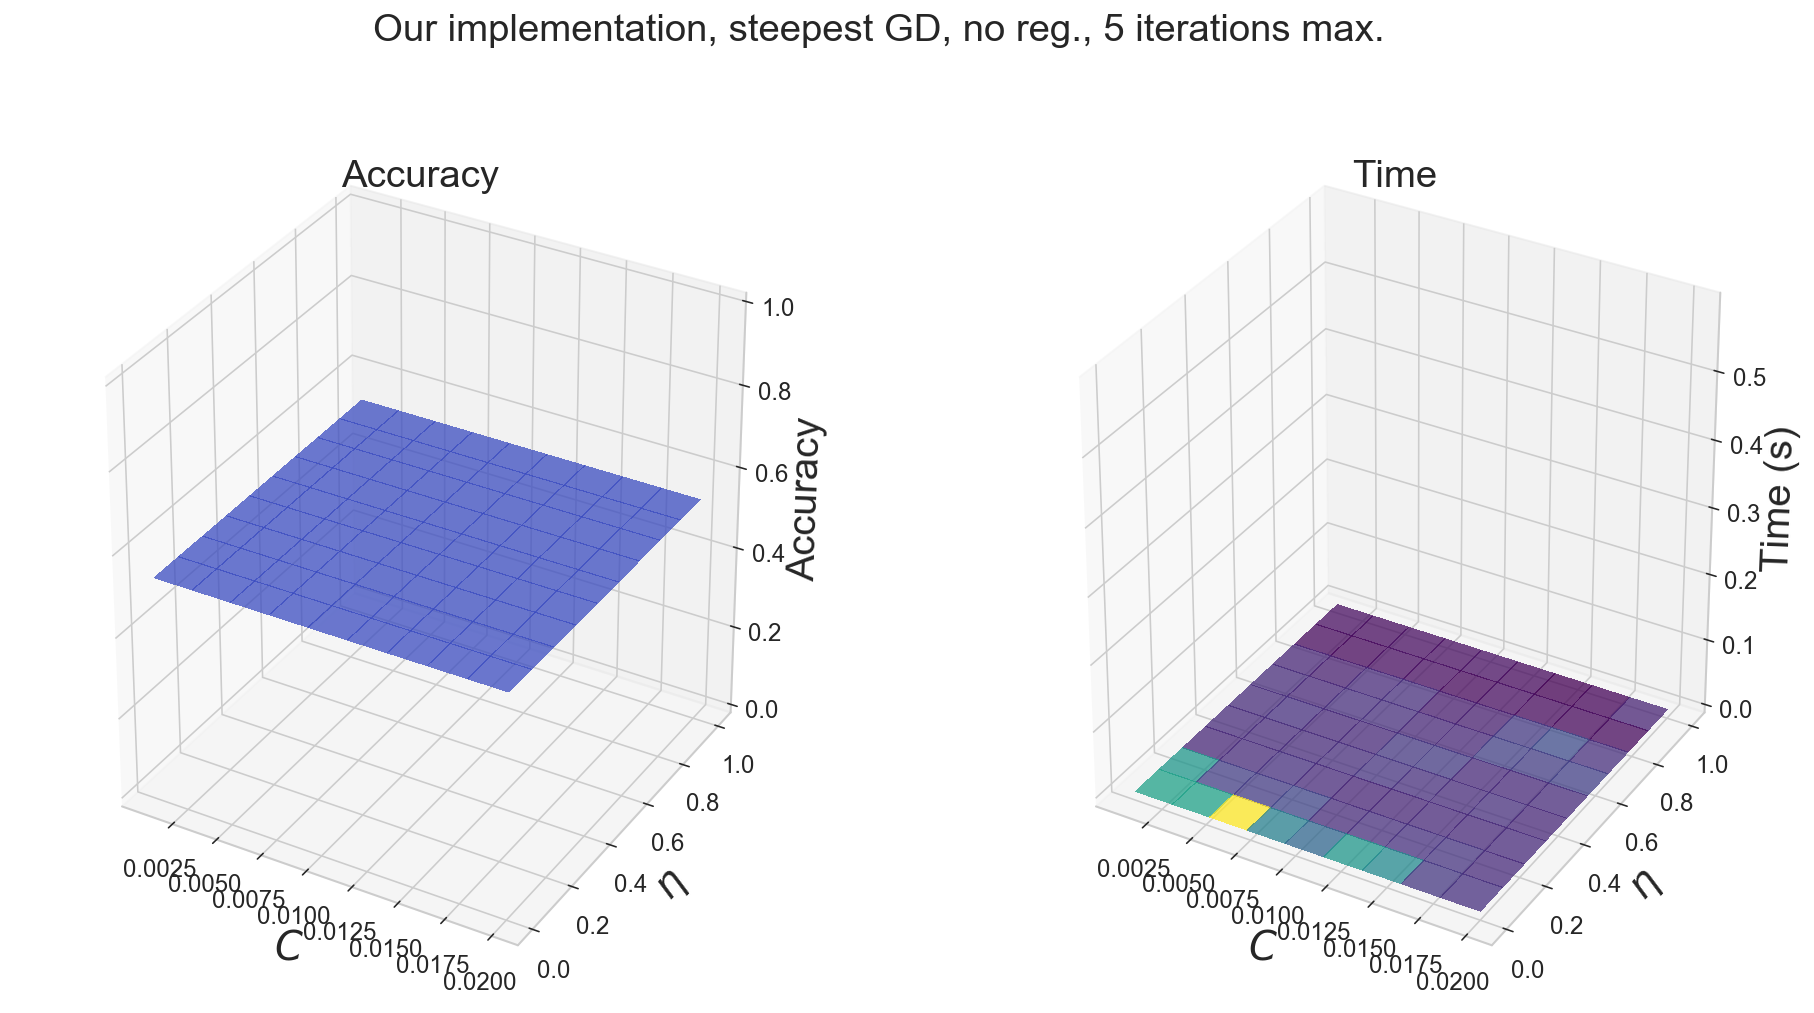

Max accuracy: 0.53378956373


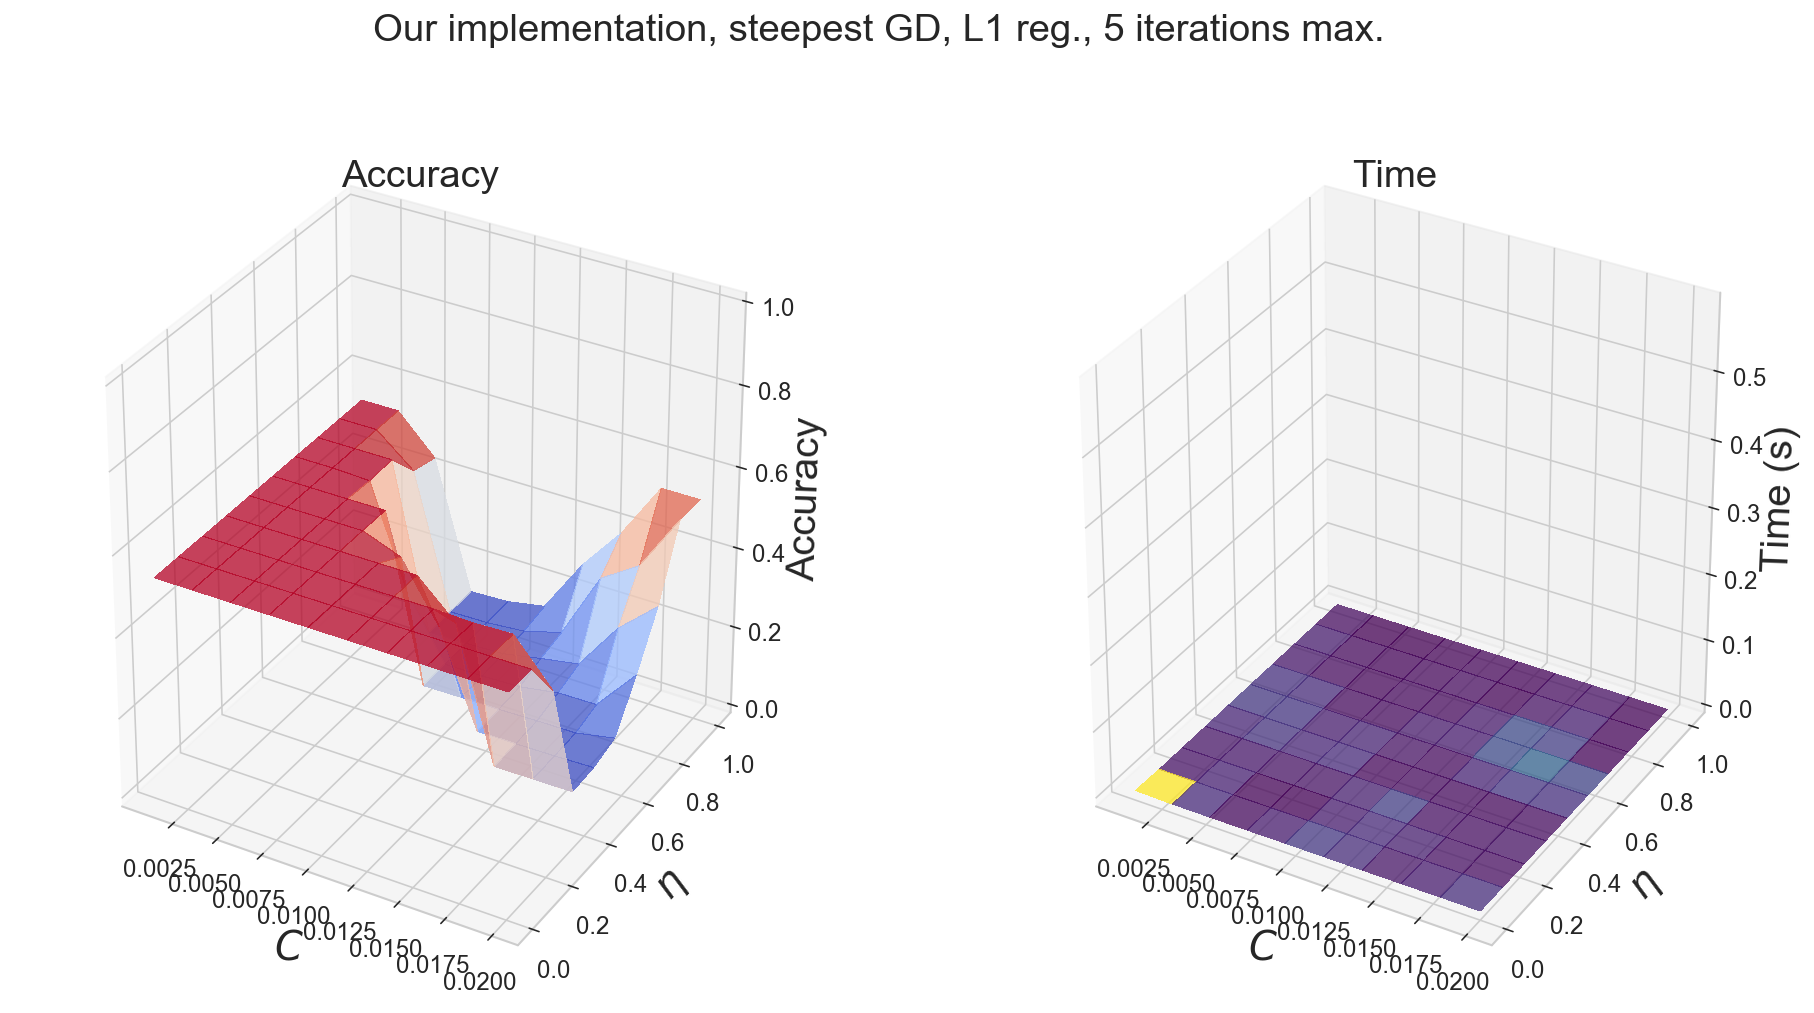

Max accuracy: 0.53378956373


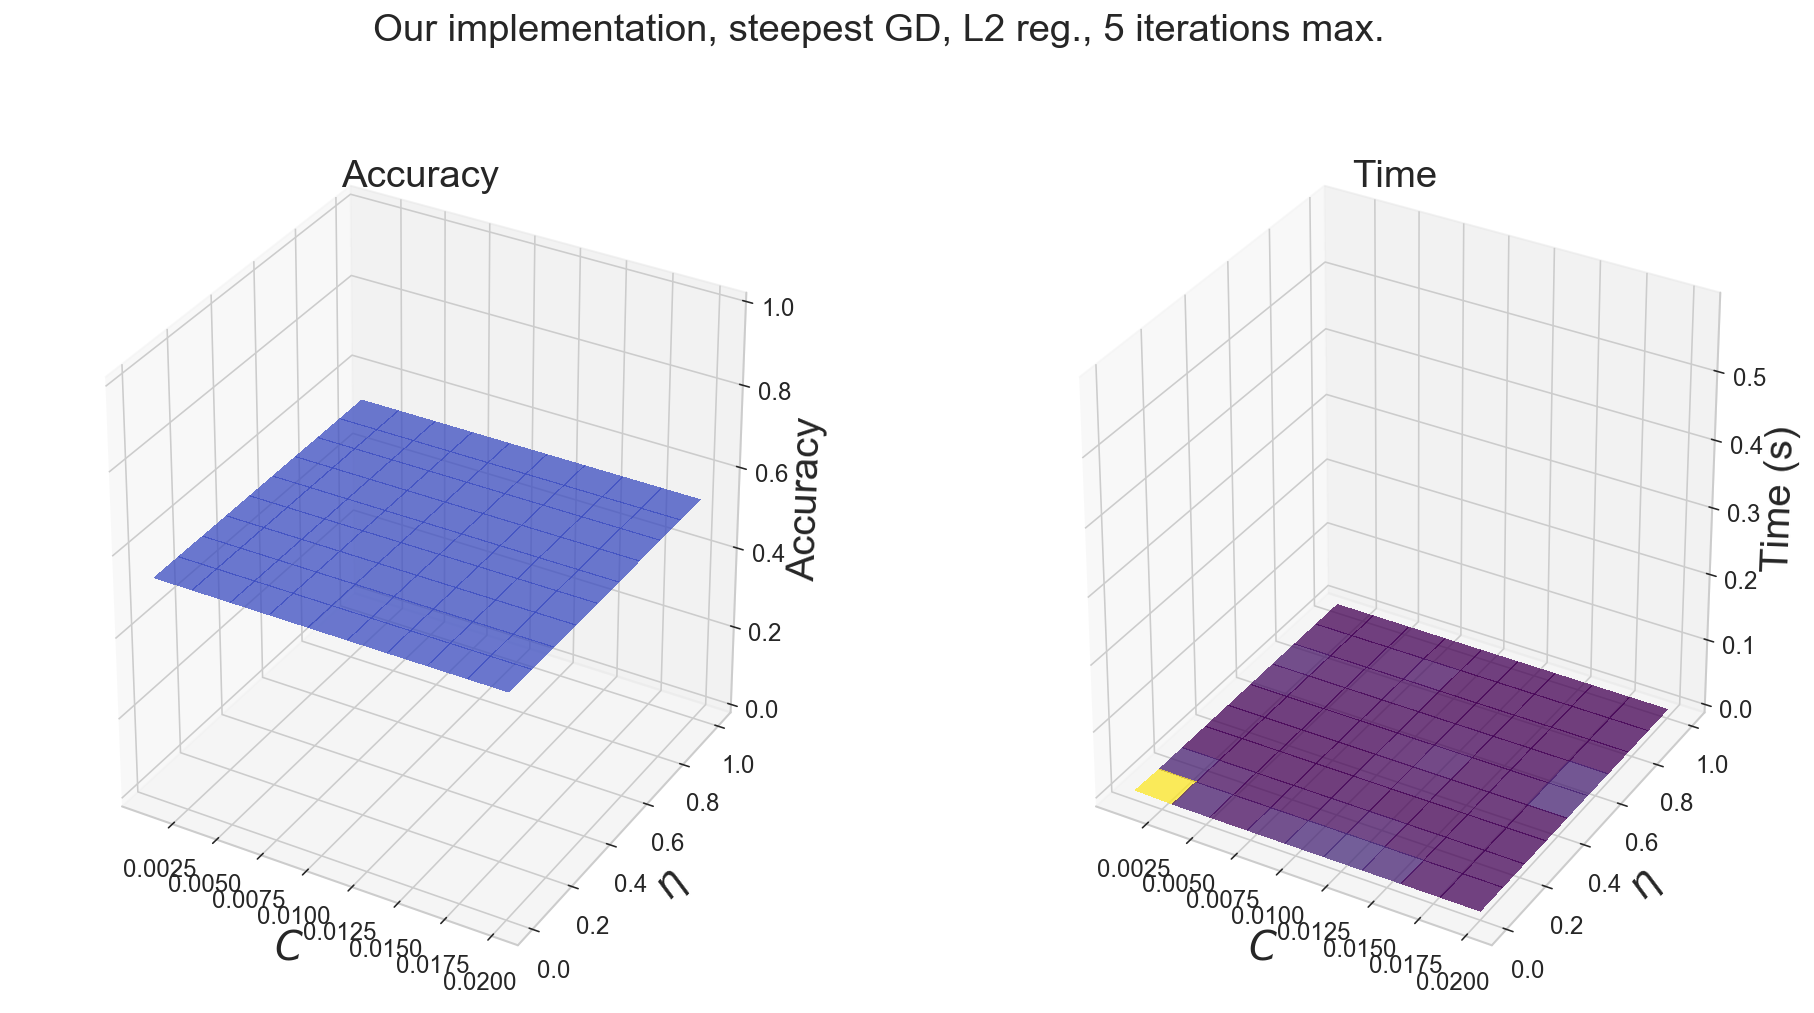

Max accuracy: 0.53378956373


/Users/paulherz/.local/share/virtualenvs/Project4-S_1fIHxr/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


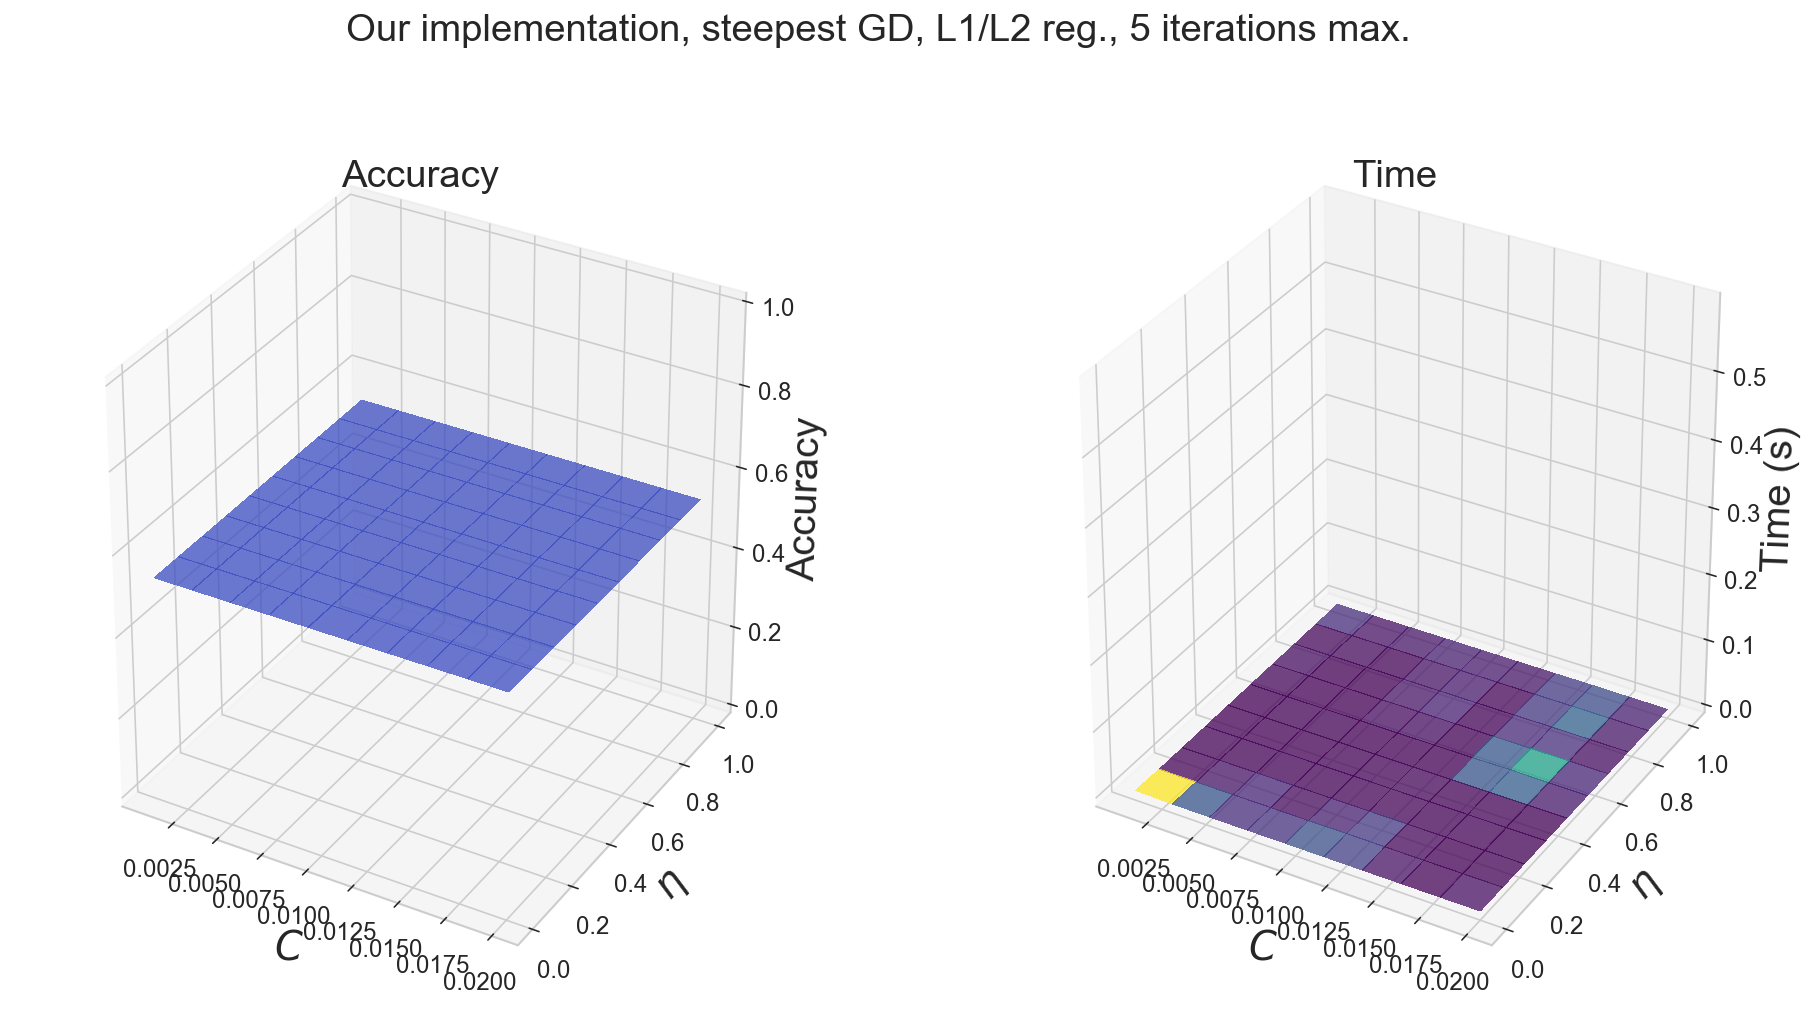

Max accuracy: 0.53378956373


In [163]:
# GD for all reg methods
plot_accuracy_and_time('Our implementation, steepest GD, no reg., 5 iterations max.',opt='GD',reg='NA')
plot_accuracy_and_time('Our implementation, steepest GD, L1 reg., 5 iterations max.',opt='GD',reg='L1')
plot_accuracy_and_time('Our implementation, steepest GD, L2 reg., 5 iterations max.',opt='GD',reg='L2')
plot_accuracy_and_time('Our implementation, steepest GD, L1/L2 reg., 5 iterations max.',opt='GD',reg='L1/L2')

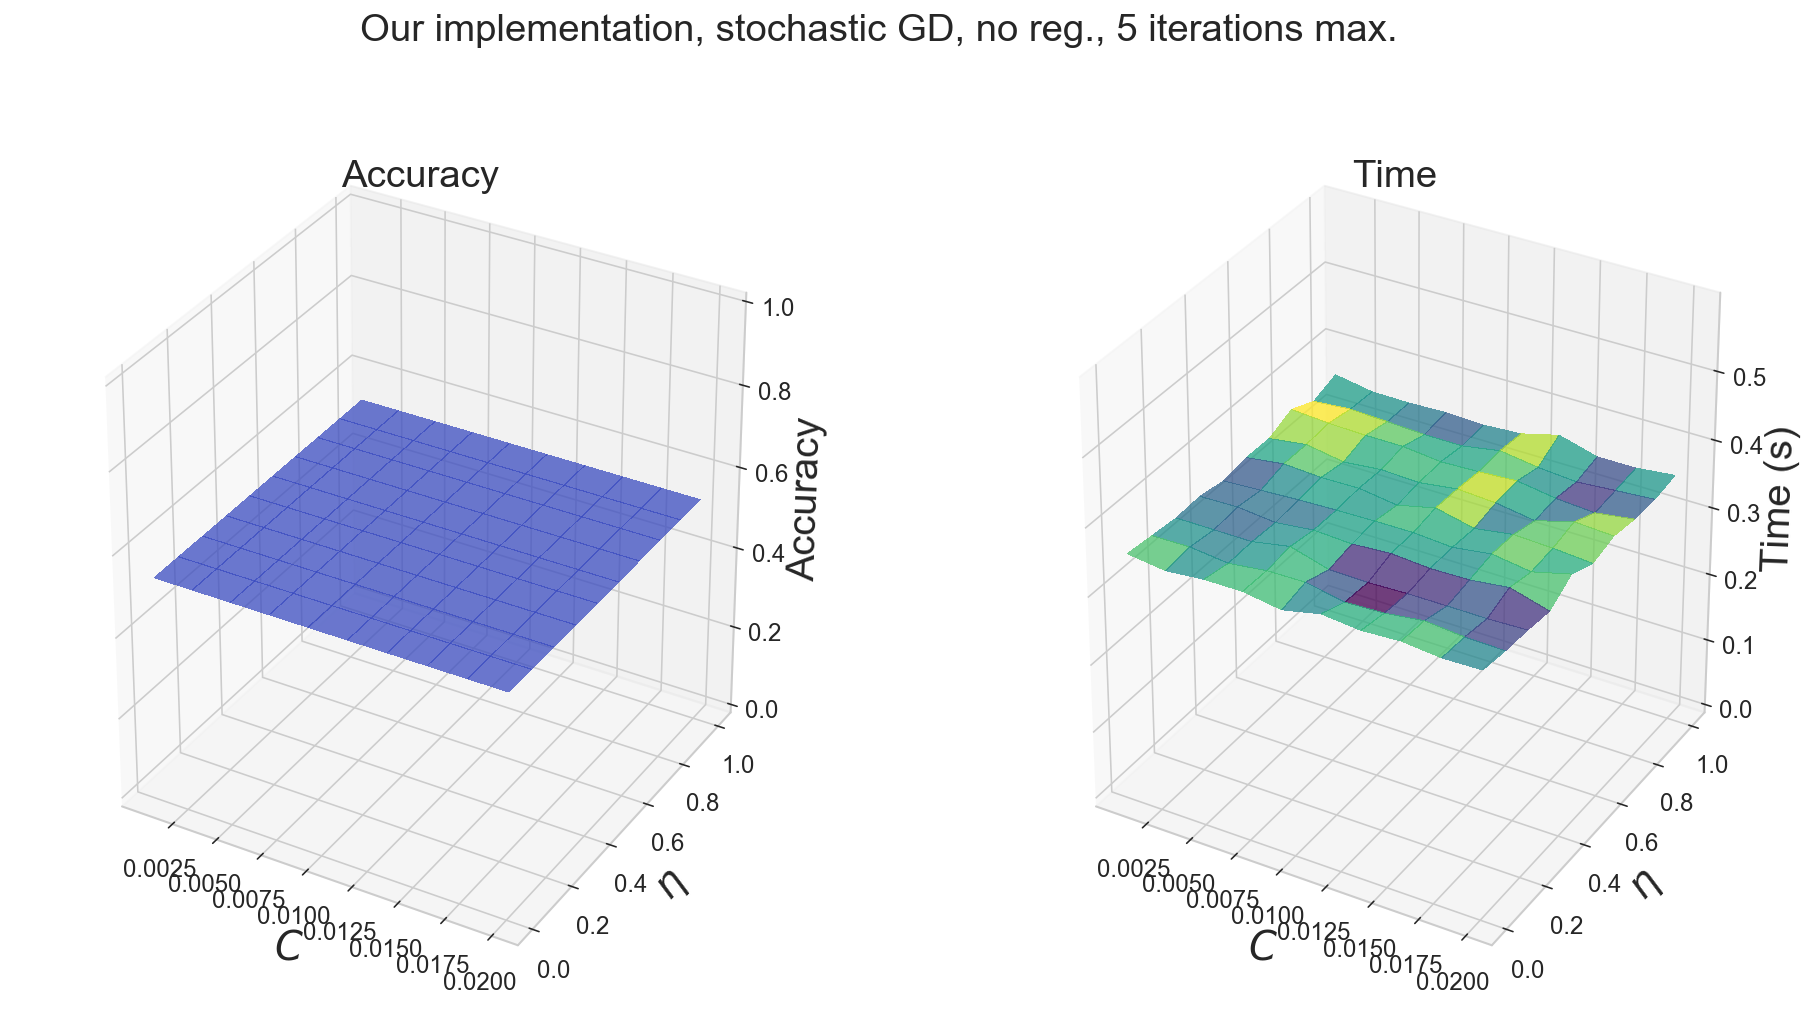

Max accuracy: 0.53378956373


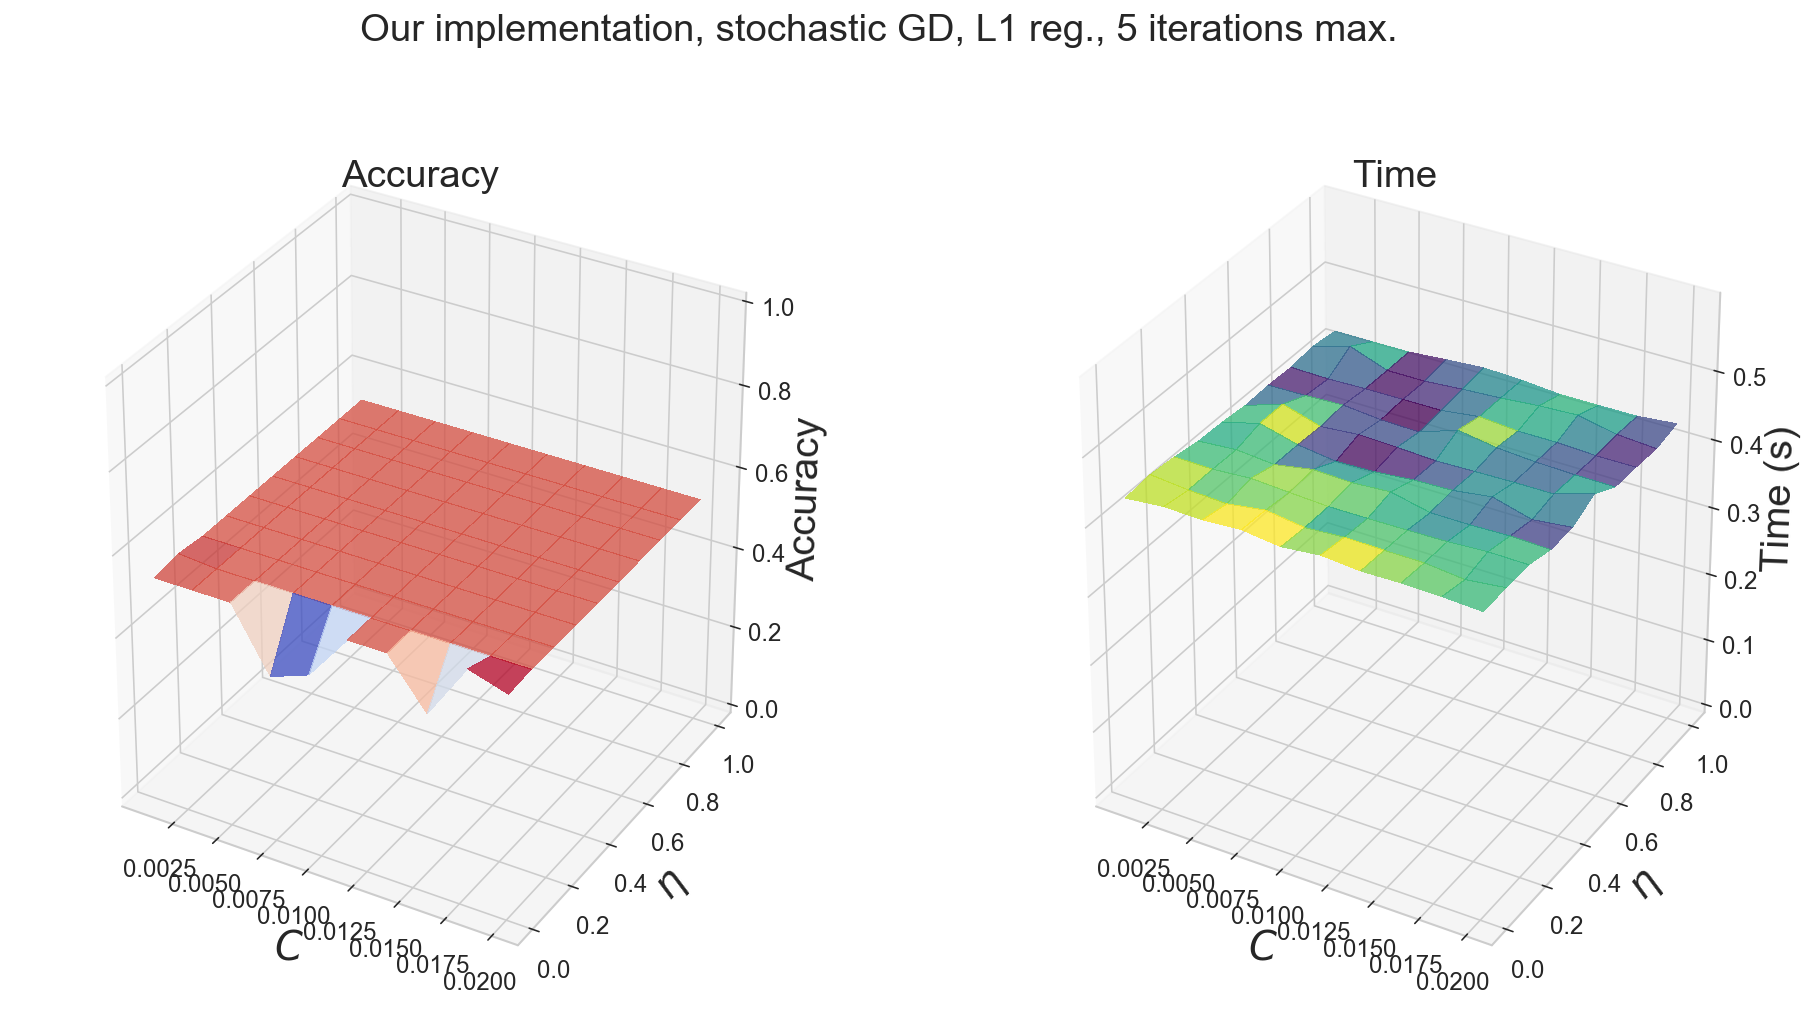

Max accuracy: 0.557313943541


/Users/paulherz/.local/share/virtualenvs/Project4-S_1fIHxr/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in multiply


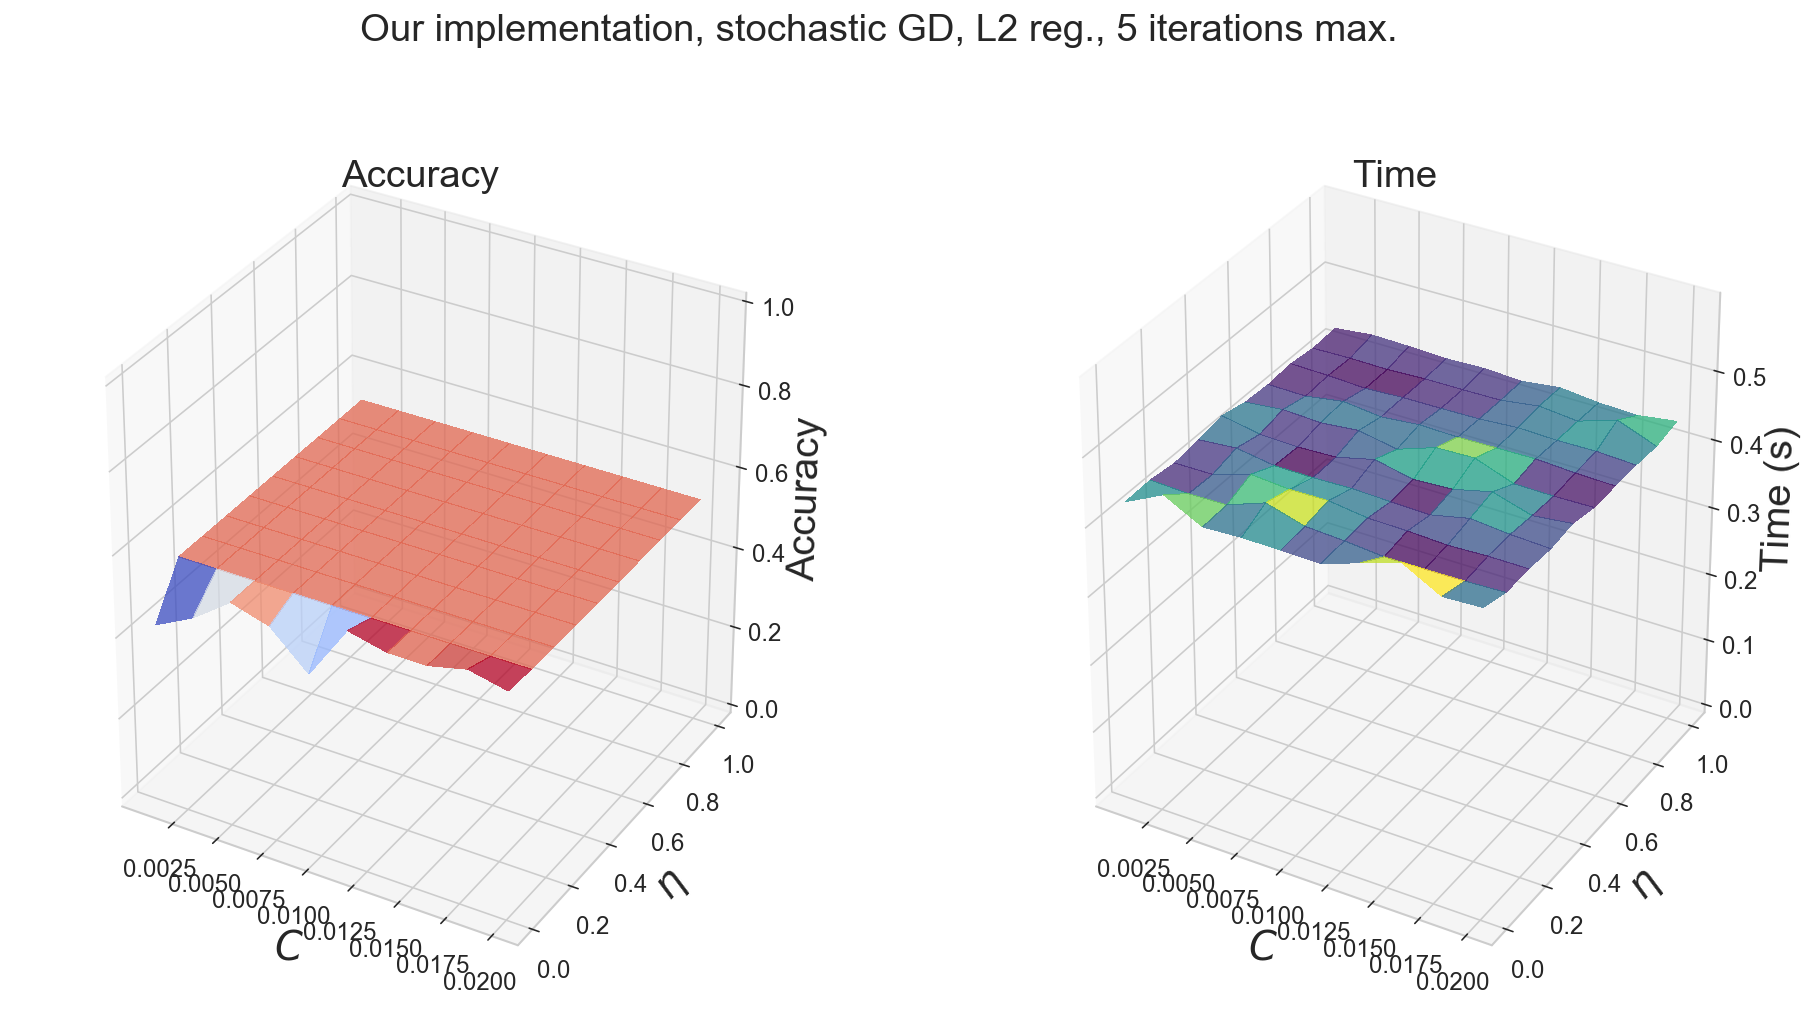

Max accuracy: 0.556458511548


/Users/paulherz/.local/share/virtualenvs/Project4-S_1fIHxr/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


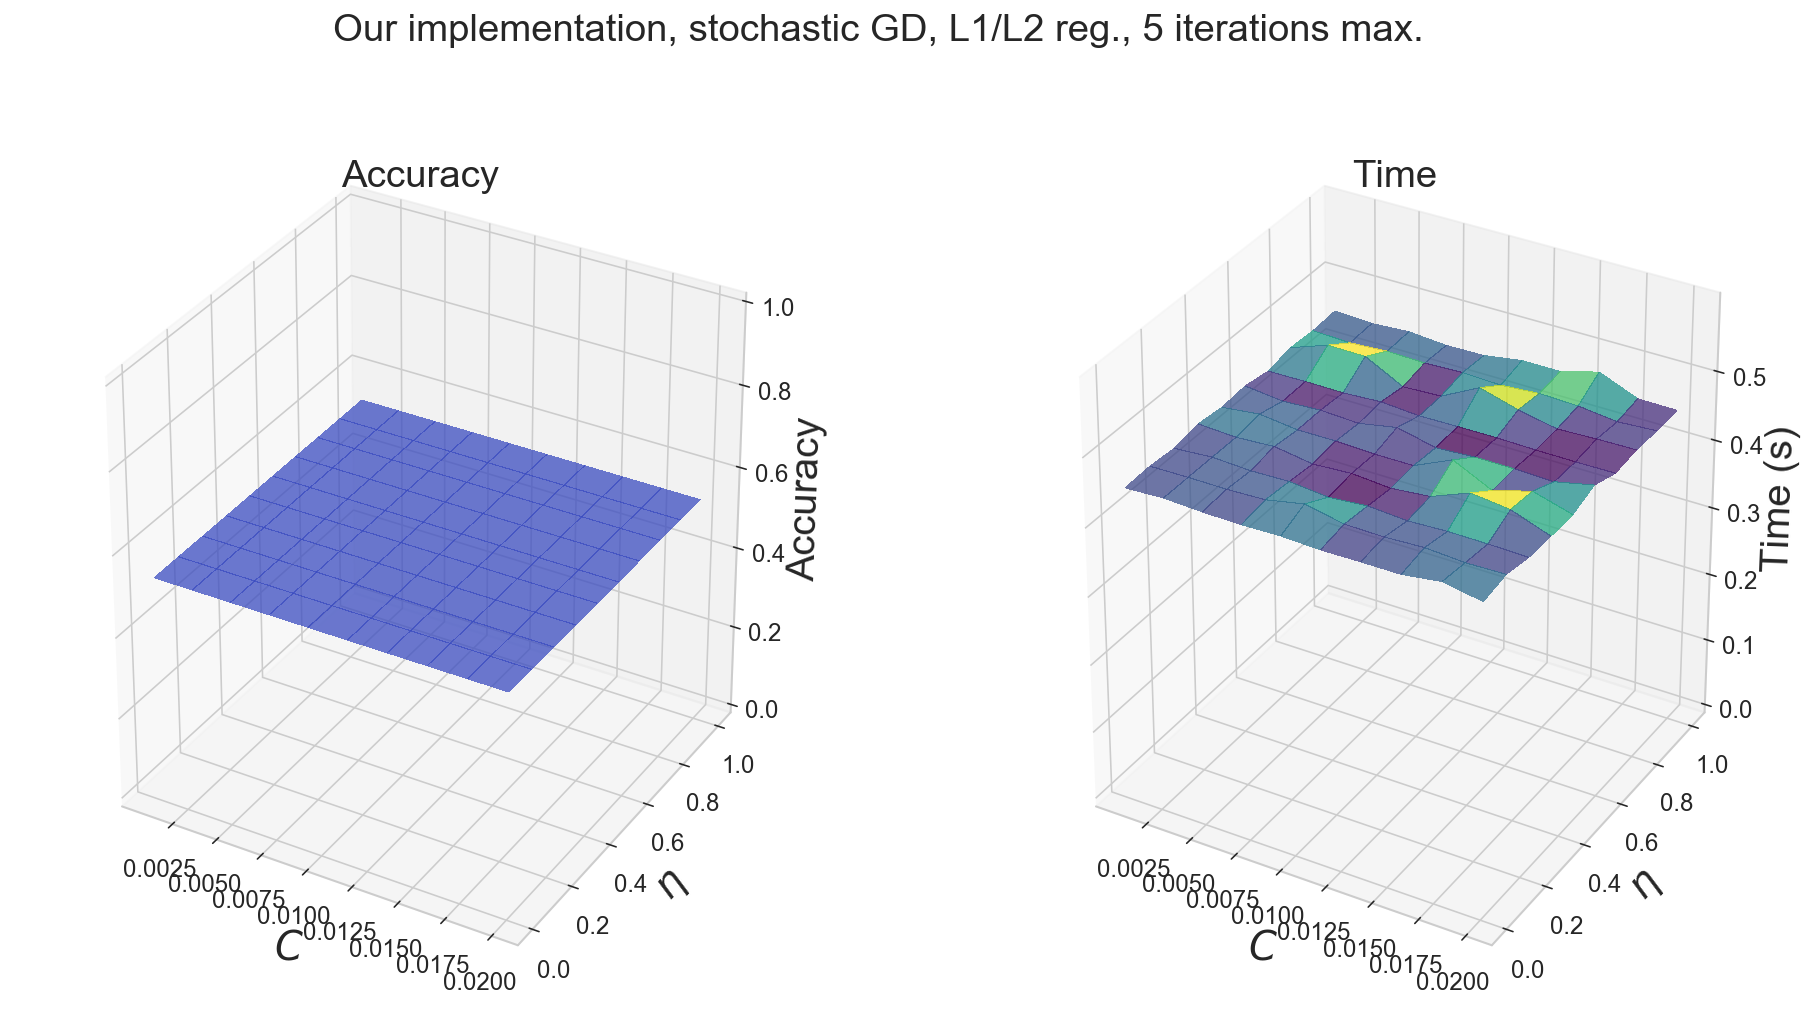

Max accuracy: 0.53378956373


In [164]:
# SGD for all reg methods
plot_accuracy_and_time('Our implementation, stochastic GD, no reg., 5 iterations max.',opt='SGD',reg='NA')
plot_accuracy_and_time('Our implementation, stochastic GD, L1 reg., 5 iterations max.',opt='SGD',reg='L1')
plot_accuracy_and_time('Our implementation, stochastic GD, L2 reg., 5 iterations max.',opt='SGD',reg='L2')
plot_accuracy_and_time('Our implementation, stochastic GD, L1/L2 reg., 5 iterations max.',opt='SGD',reg='L1/L2')

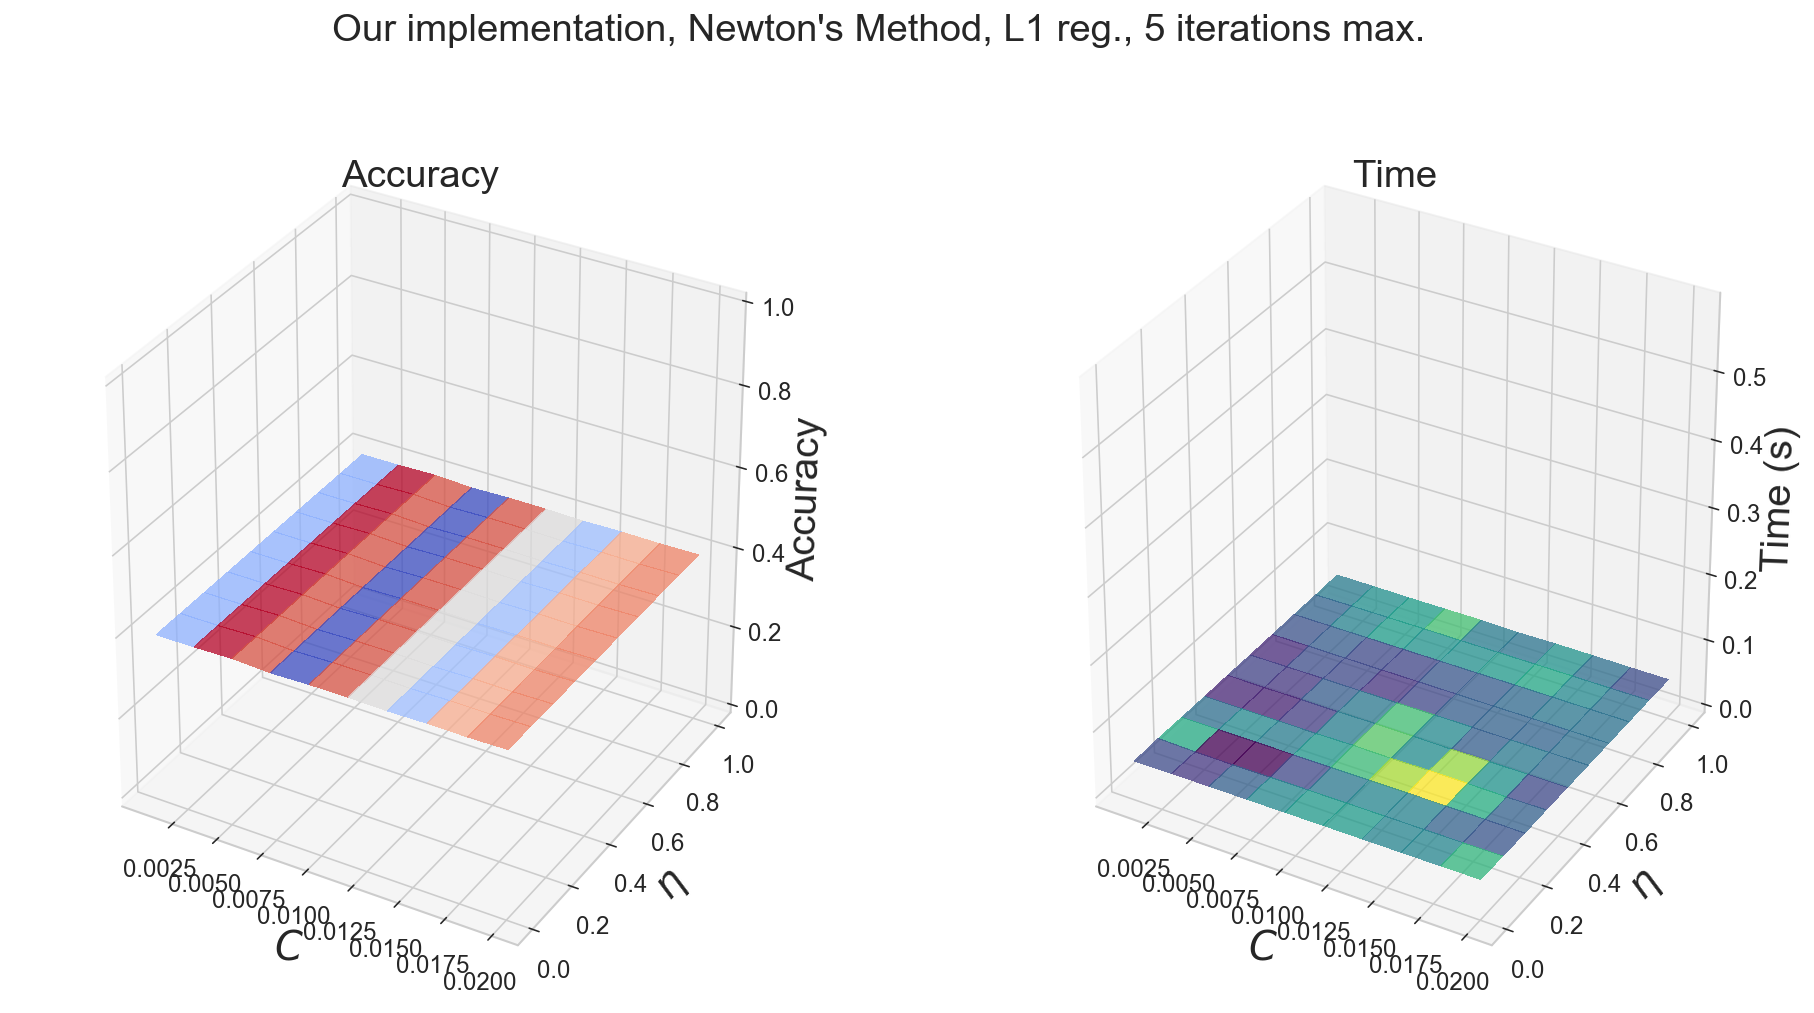

Max accuracy: 0.397775876818


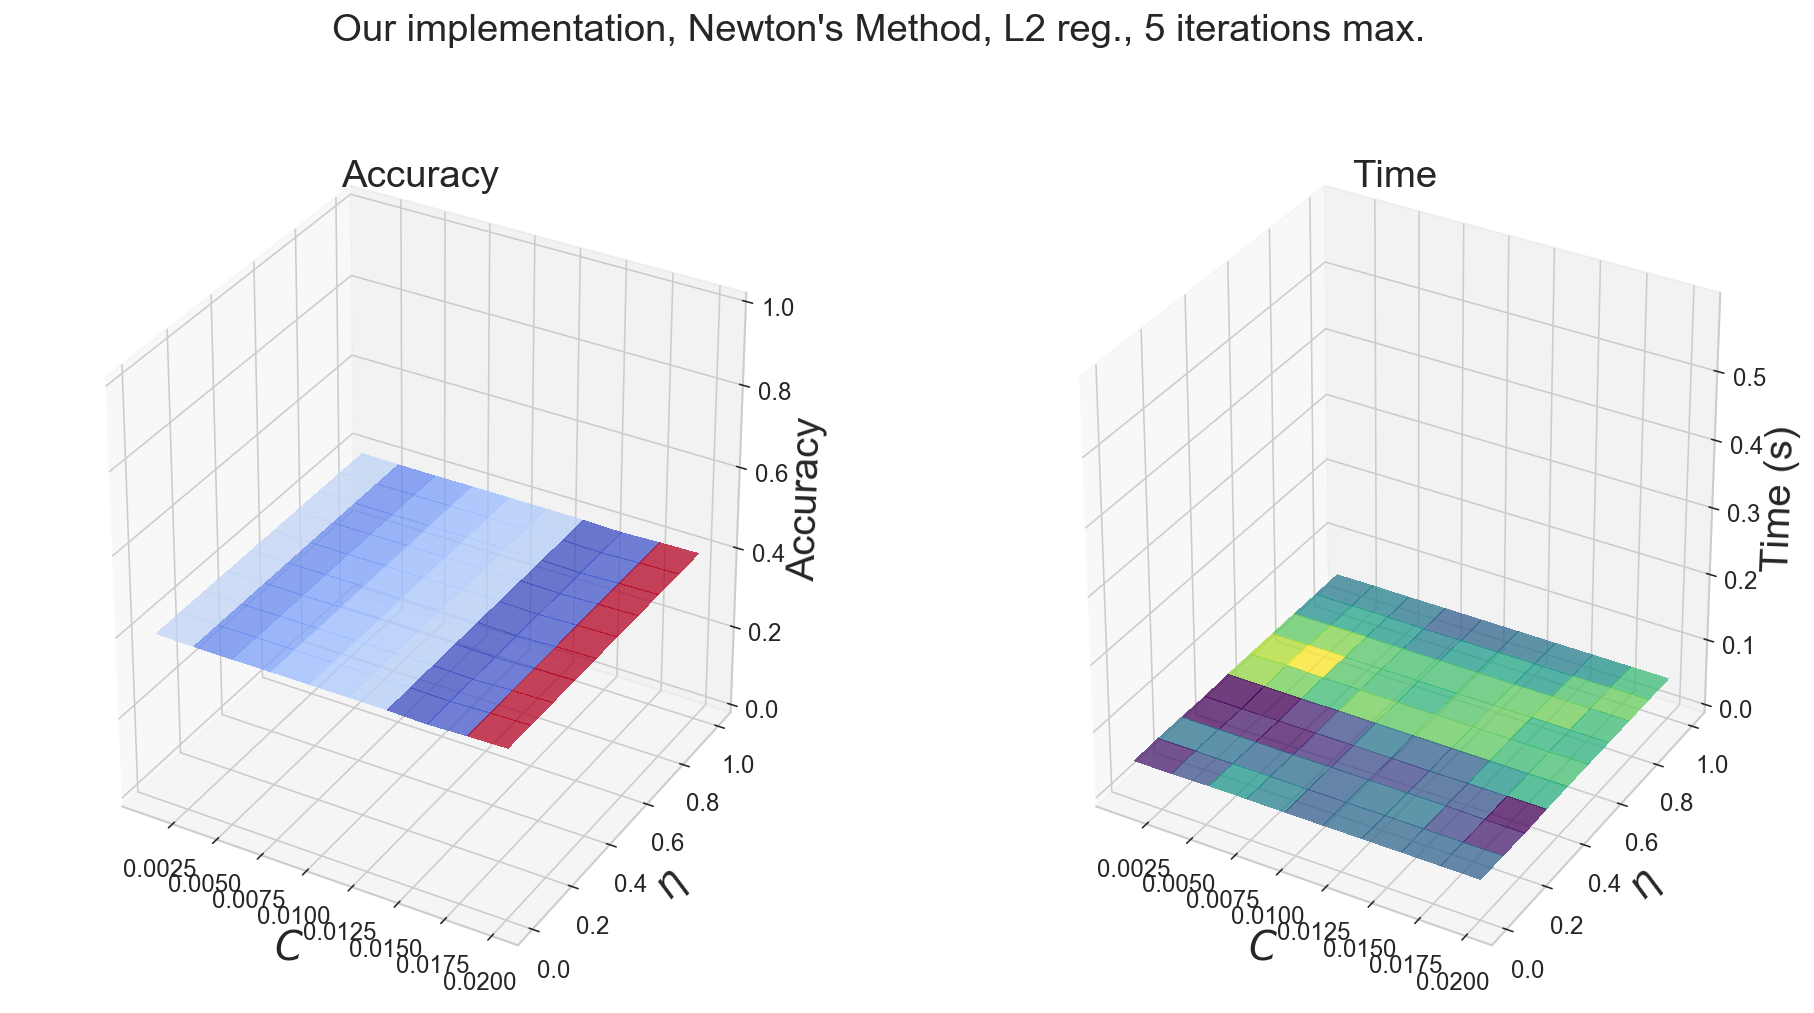

Max accuracy: 0.399914456801


/Users/paulherz/.local/share/virtualenvs/Project4-S_1fIHxr/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


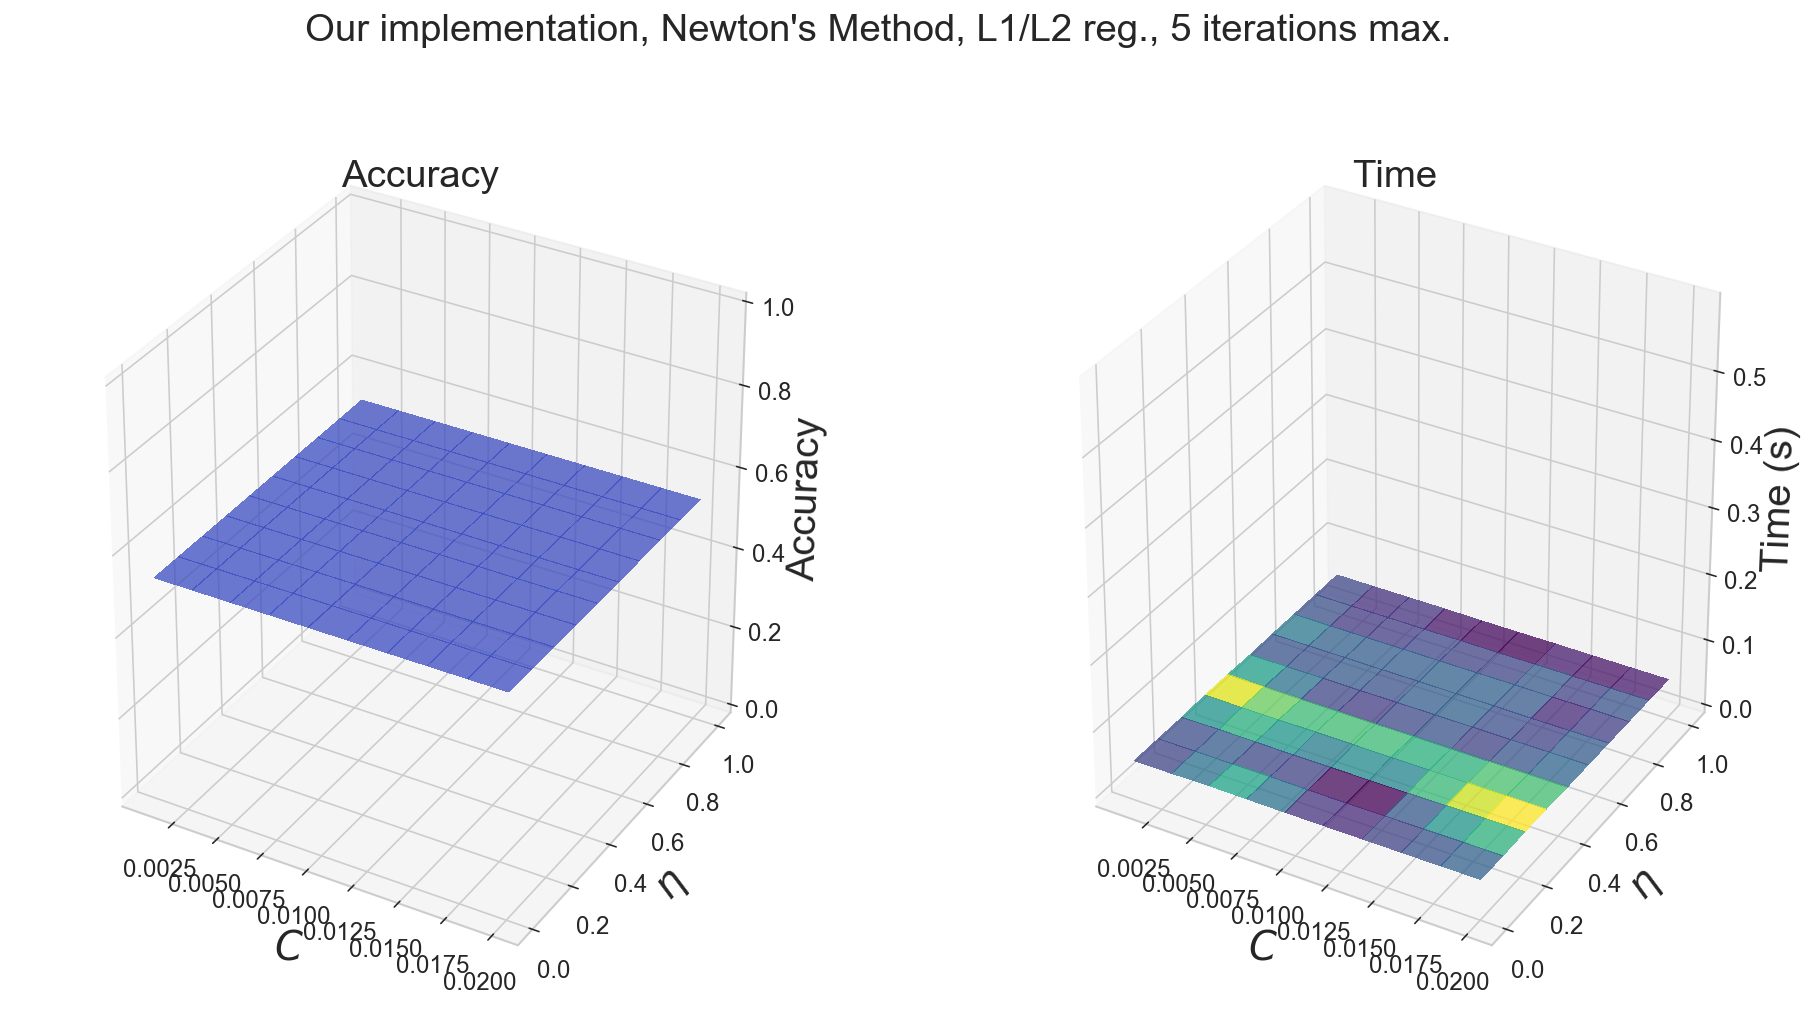

Max accuracy: 0.53378956373


In [165]:
# Newton for all reg methods
#plot_accuracy_and_time('Our implementation, Newton\'s Method, no reg., 5 iterations max.',opt='NWT',reg='NA')
plot_accuracy_and_time('Our implementation, Newton\'s Method, L1 reg., 5 iterations max.',opt='NWT',reg='L1')
plot_accuracy_and_time('Our implementation, Newton\'s Method, L2 reg., 5 iterations max.',opt='NWT',reg='L2')
plot_accuracy_and_time('Our implementation, Newton\'s Method, L1/L2 reg., 5 iterations max.',opt='NWT',reg='L1/L2')

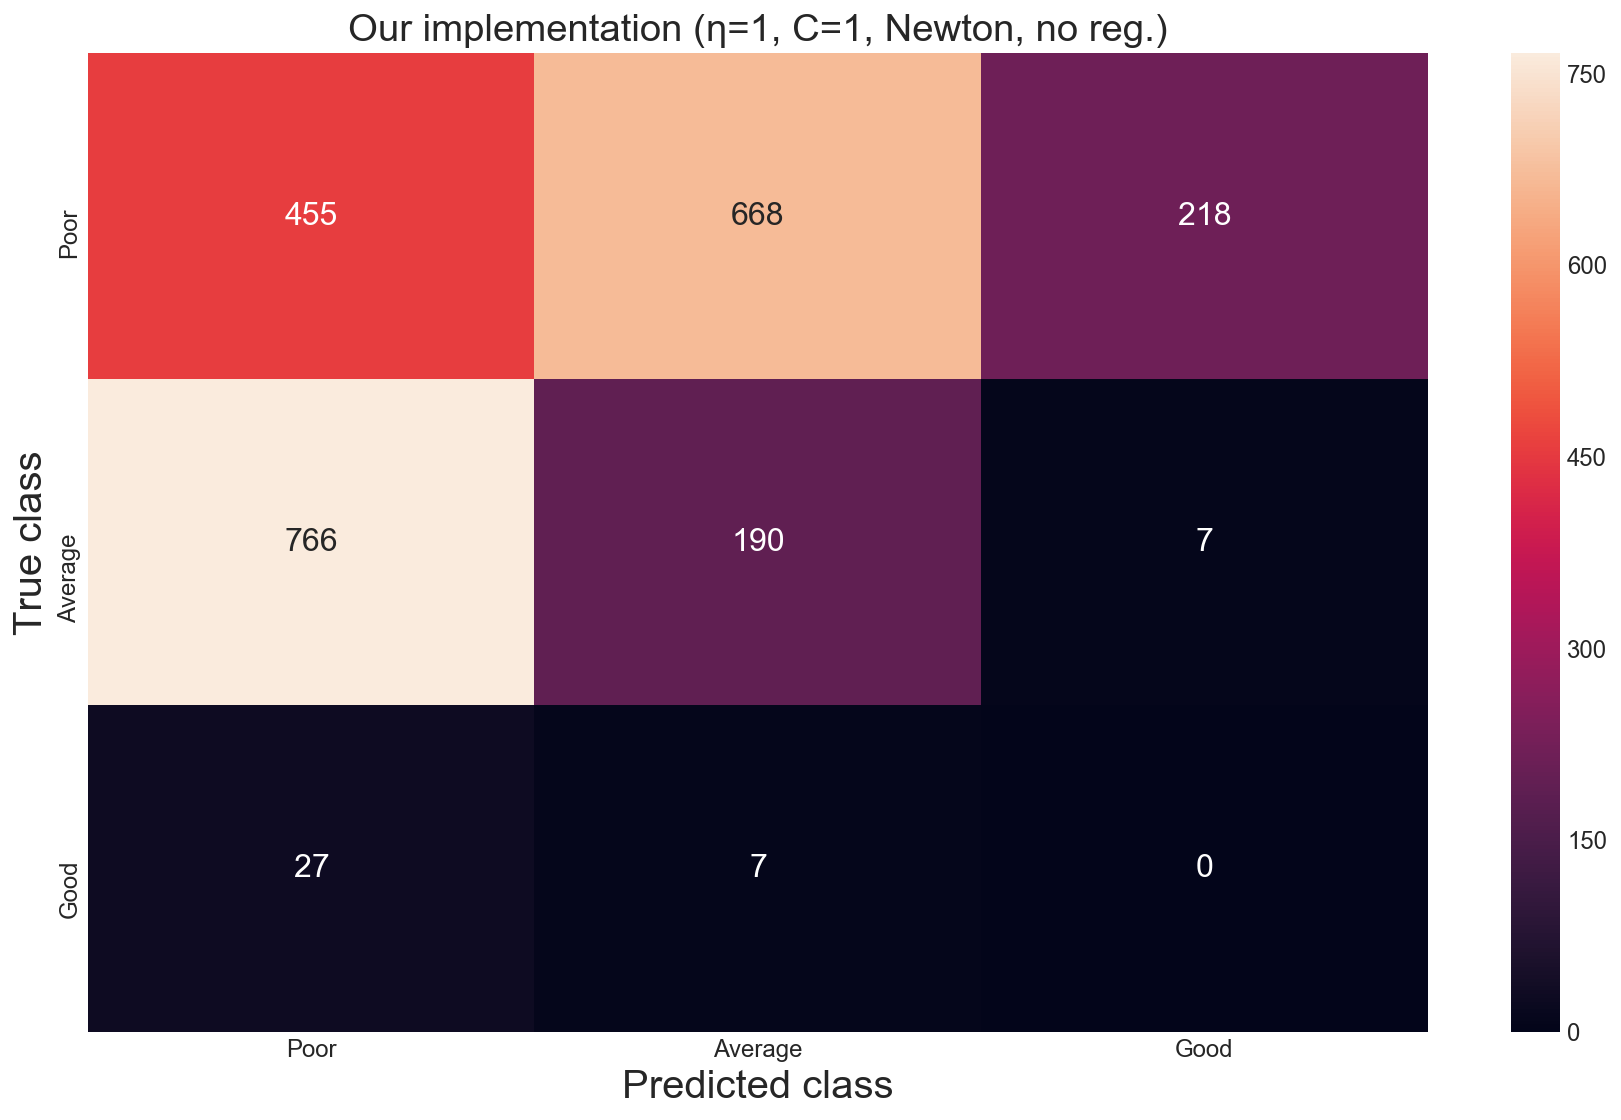

Accuracy: 0.2759


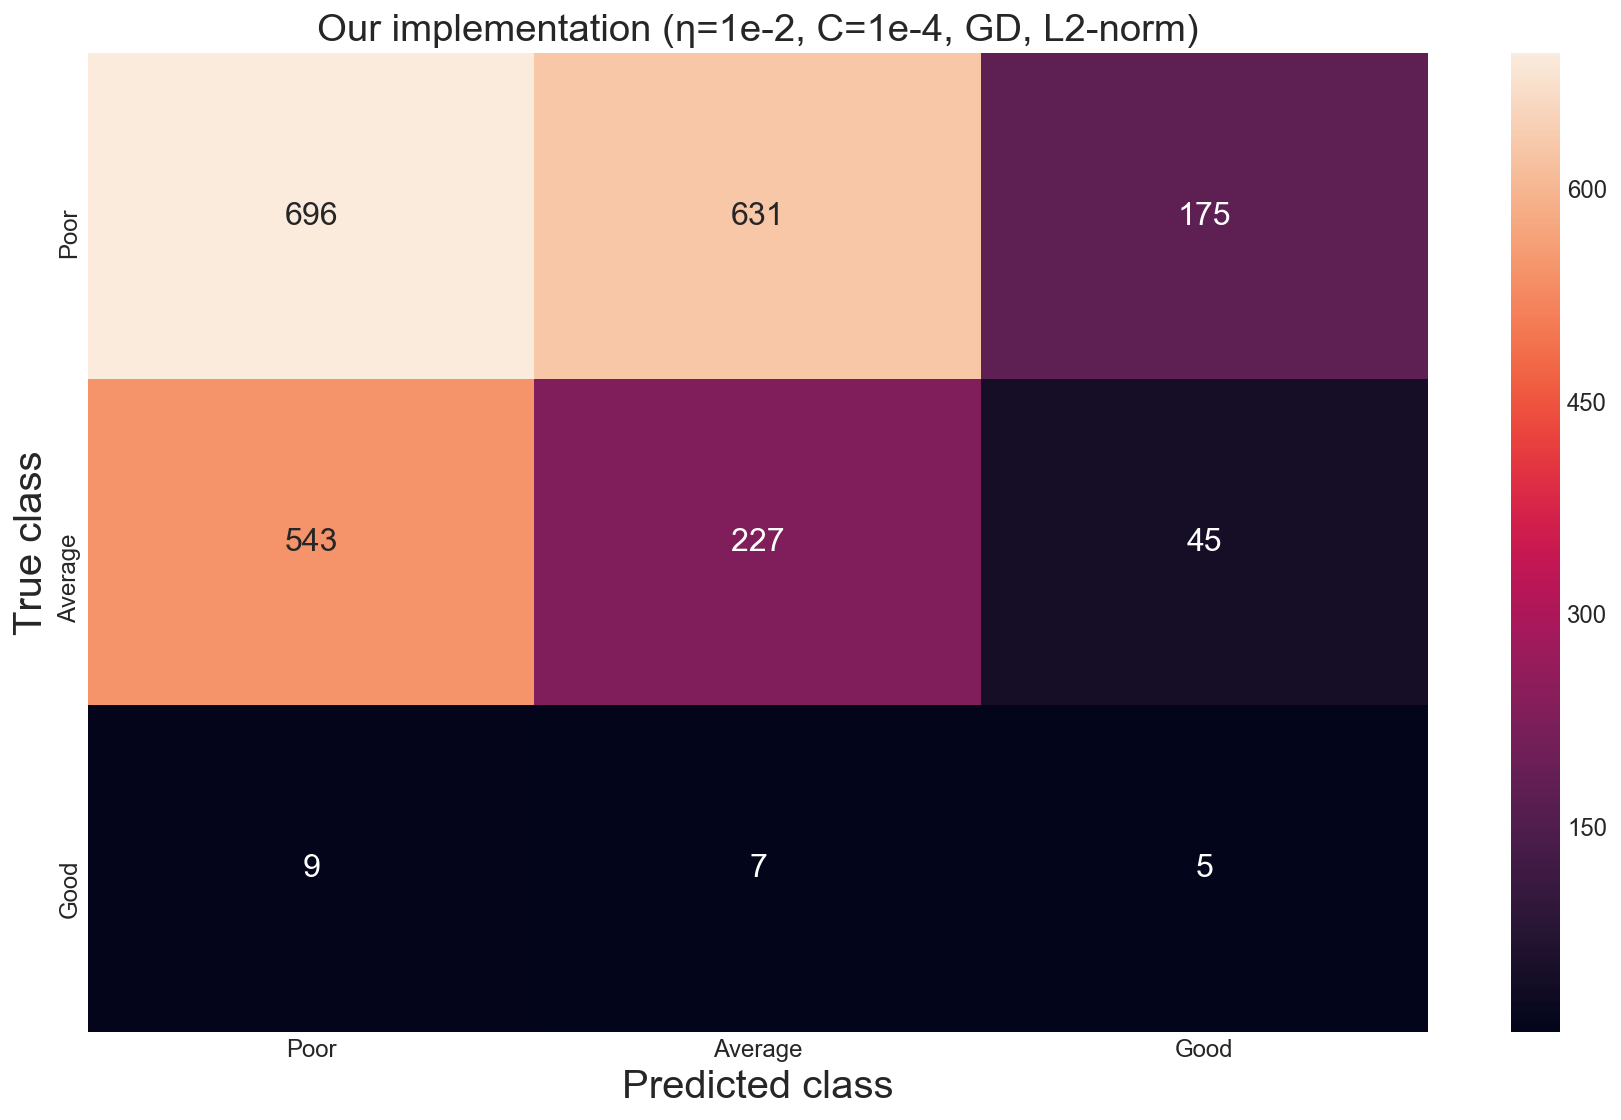

Accuracy: 0.3969


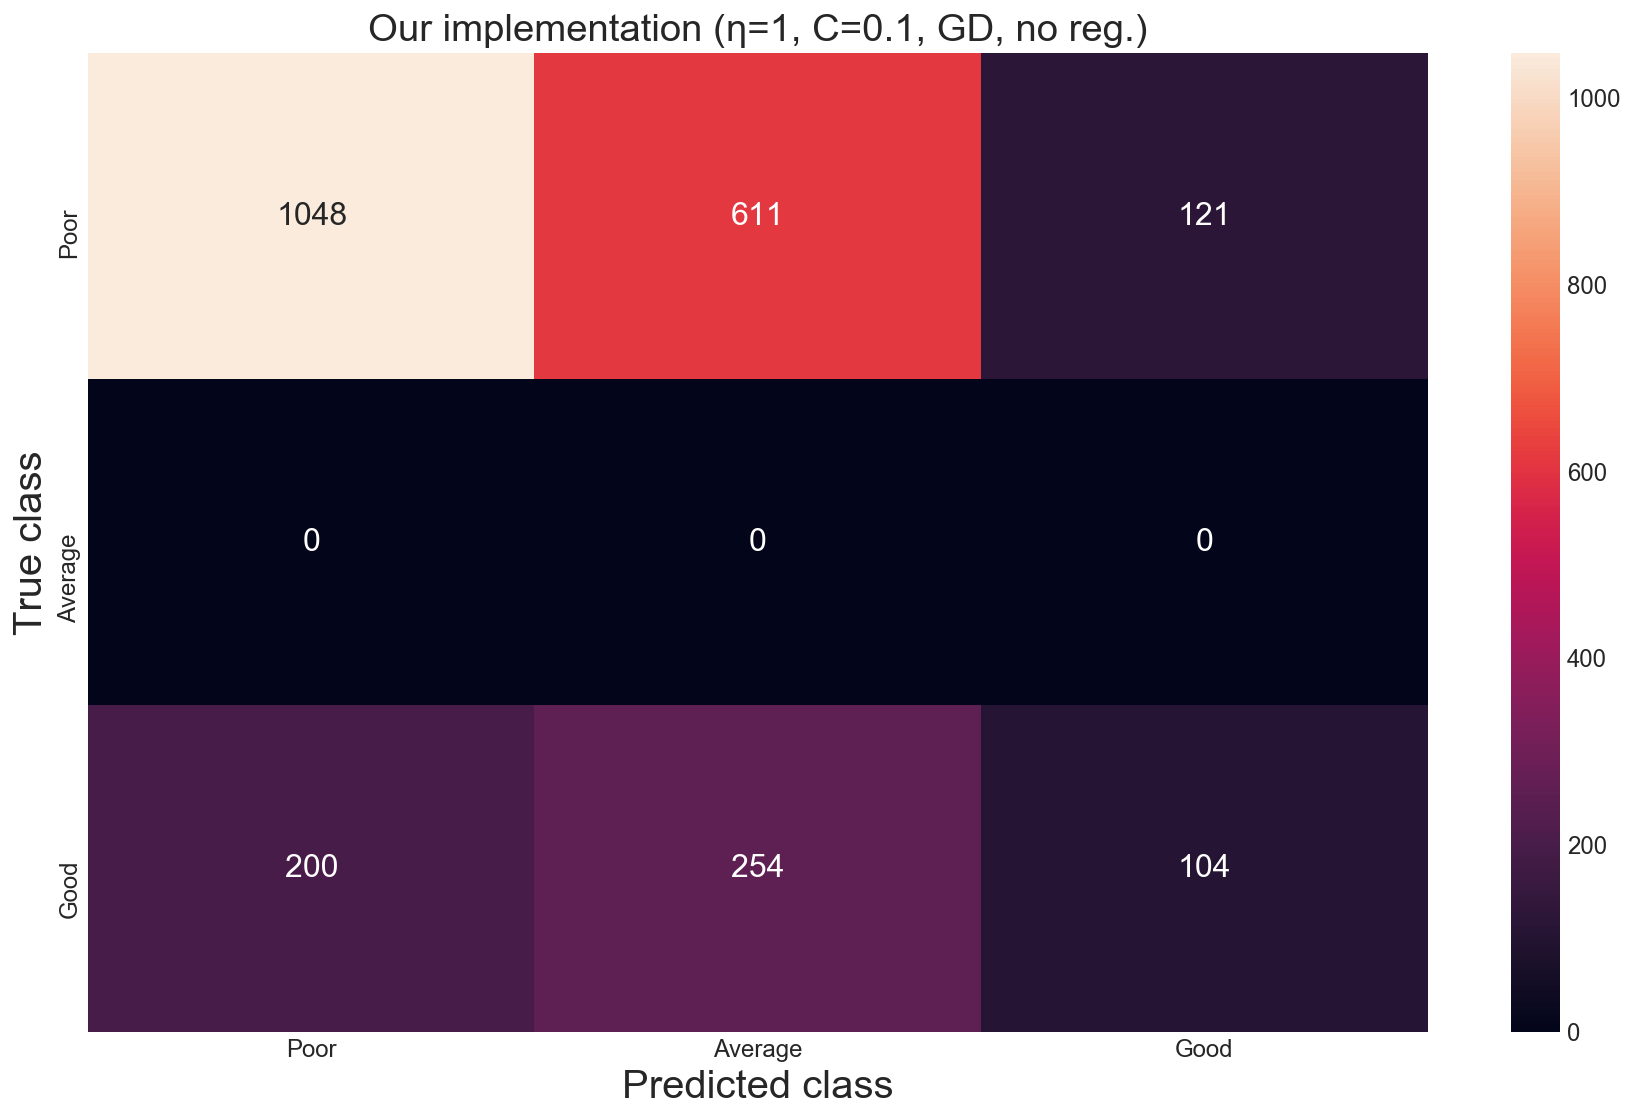

Accuracy: 0.4927


In [181]:

multiR_two = MultiClassRegression(eta=1, maxIter=10, C=1, opt='NWT', reg='NA')
multiR_two.fit(X_train, y_train)
pred_two = multiR_two.predict(X_predict)
confusion_matrix_graph(pred_two,y_predict,title='Our implementation (η=1, C=1, Newton, no reg.)')


multiR_three = MultiClassRegression(eta=0.01, maxIter=5, C=0.0001, opt='NWT', reg='L2')
multiR_three.fit(X_train, y_train)
pred_three = multiR_three.predict(X_predict)
confusion_matrix_graph(pred_three,y_predict,title='Our implementation (η=1e-2, C=1e-4, GD, L2-norm)')


multiR_one = MultiClassRegression(eta=1, maxIter=500, C=0.1, opt='GD', reg='NA')
multiR_one.fit(X_train, y_train)
pred_one = multiR_one.predict(X_predict)
confusion_matrix_graph(pred_one,y_predict,title='Our implementation (η=1, C=0.1, GD, no reg.)')


### 3.3 Comparing scikit-learn's LogisticRegression
using scikit-learn's `LogisticRegression` module, setting it to take a one-versus-rest (OVR) approach to multi-class classification.

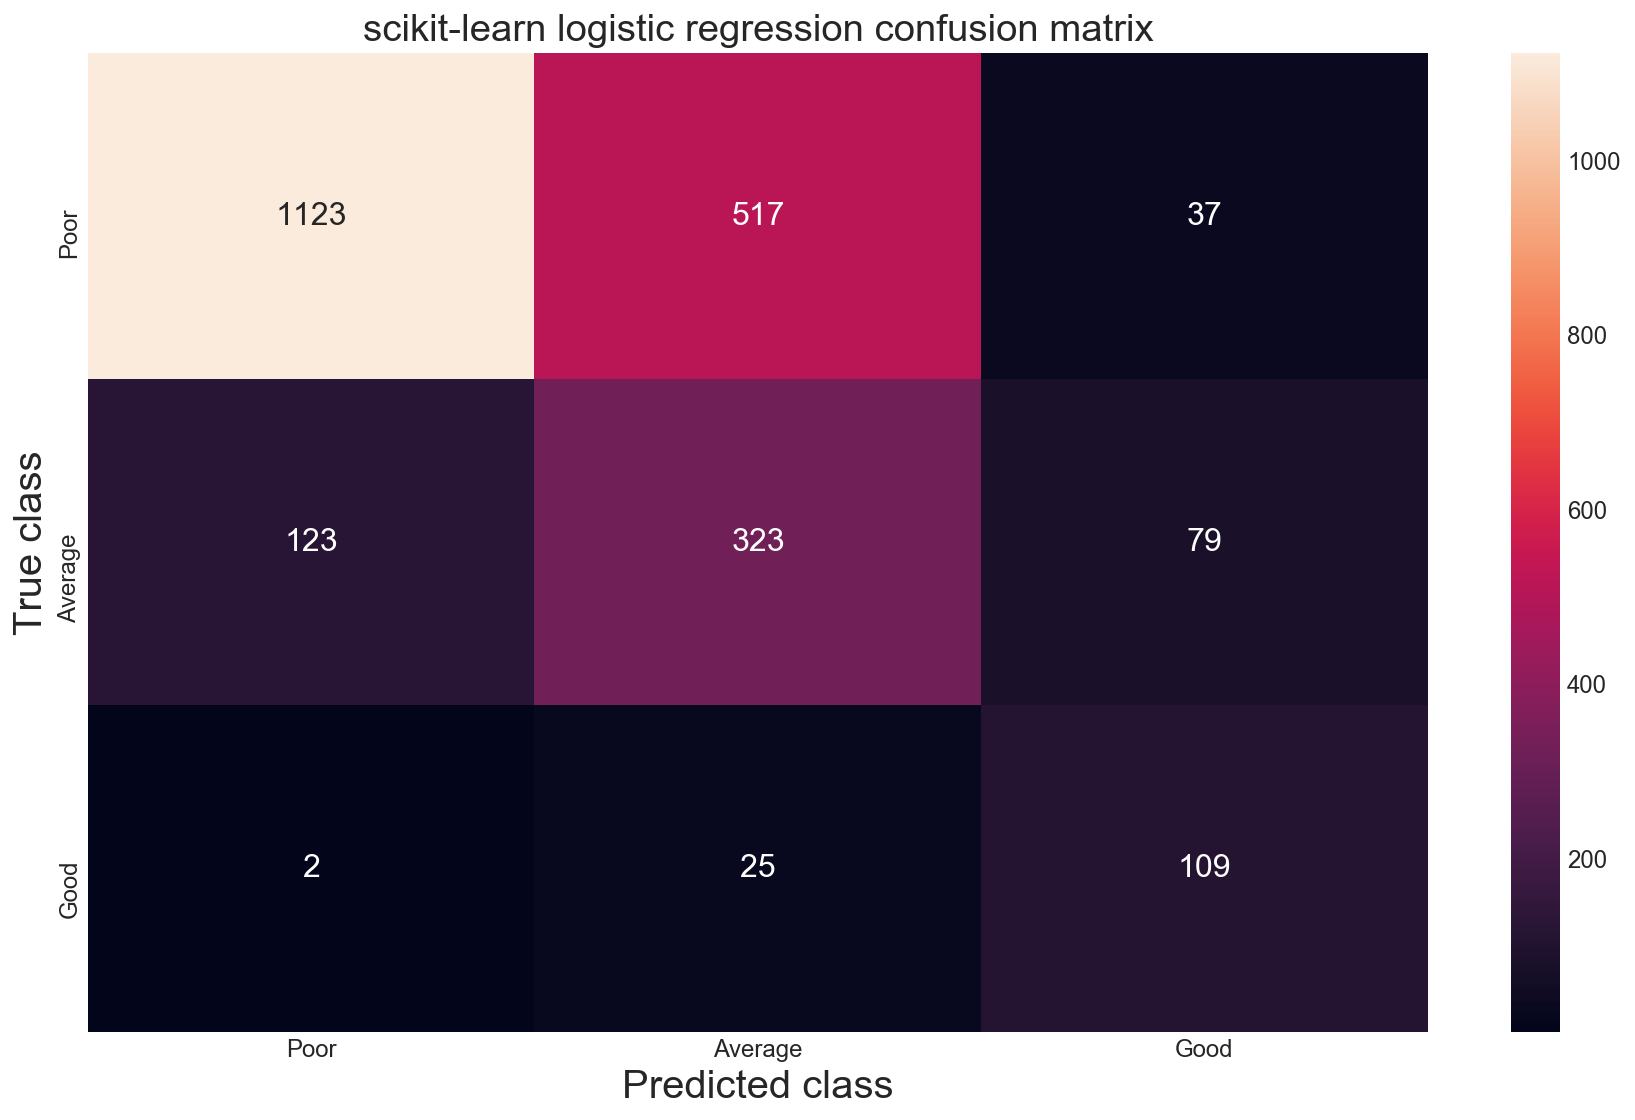

Accuracy: 0.6651


In [170]:
# Training: scikit-learn's logistic regression classifier, one-versus-rest

logistic = linear_model.LogisticRegression(multi_class='ovr')
logistic.fit(X_train,y_train)

# Testing

y_predict_hat = logistic.predict(X_predict)
confusion_matrix_graph(y_predict_hat,y_predict,'scikit-learn logistic regression confusion matrix')

### 3.4 Observations
#### Data Snooping
Inevitably, the methodology we use above is not generalizable, as we tweak the parameters of the regression classifier and how it trains based on results we get to see from predicting the test data, making the test data no more than glorified manual training data.

#### Performance
Looking at the first set of 3D plots, it appears that our implementation performs decently, but upon observation of the confusion matrices here, it is clear that on a per-class basis, our method does not perform fantastically upon *this* dataset. **The biggest problem** is that we have defined arbitrary lines in a nonclustered dataset, so the bleed between classes is very high. We believe that our algorithm would perform better on a distinctly clustered dataset rather than a single cluster that has been arbitrarily subdivided.

#### Deployment
We would prefer to use the scikit-learn implementation of `LinearRegression` over ours. Most importantly, it appears that our implementation still suffers from some shortcomings with class accuracy. Even if it were to function perfectly, our implementation has not been as rigorously tested and studied as those present in community-sourced libraries like scikit-learn, and even if we can demonstrate a slightly higher degree of accuracy in our model when it is configured specifically, that does not rationalize its use in a performance critical setting like an ML model. Furthermore, our implementation has not been optimized for high parallelism or GPU compute like many other implementations (not necessarily scikit's) have been.